# Table of Contents
- [Processing Functions](#Process-functions)
- [Import Data](#import-data)
  - [Histograms](#Histograms)
  - [Counts files](#counts)
- [Processing](#processing)
- [Plotting](#plotting)
  - [HeLaS3 titration of H3K9ac](#LP78-HeLaS3-titration-of-H3K9ac)
  - [QCs for Biased and Unbiased Libraries](#QCs-)
  - [HeLaS3 titration of H3K27ac](#LP100-HeLaS3-titration-of-H3K27ac)
- [Spike-in Normalize](#spike-in-normalize)
  - [dual norm with confidence intervals](#dual-norm-with-confidence-intervals)

---

In [3]:
library(tidyverse)
theme_set(theme_classic())
library(DescTools)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Processing Functions

## Processing HOMER Histograms

The functions: `process_histograms_dm6` `process_histograms_sac3` and `process_histograms_hg38` work with histogram files generated with HOMER annotatePeaks with -hist option. More details are available [on the HOMER tutorial website](http://homer.ucsd.edu/homer/ngs/quantification.html).

Making the histogram: 

`annotatePeaks.pl [region_to_center_on] [genome_version] -size [size_to_plot] -hist [bp_resolution] -d [tag directories] > histogram_regions_genome_datasource.txt`

Example for a TSS histogram in the hg38 genome: 

`annotatePeaks.pl tss hg38 -size 4000 -hist 25 -d sample1-tagdir sample2-tagdir input1-tagdir input2-tagdir > hist_tss_hg38_samples12.txt`

Input file: histogram_regions_genome_datasource.txt 

Output: dataframe in tidy (long) format, with additional columns describing the metadata originally in each sample name:
- Cell Type
- Treatment
- Timepoint
- Biological Replicate
- Antibody (usually I have multiple IP samples from each biological sample/replicate)
- Technical Replicate (separate library preps from the same biological sample/replicate)

In [49]:
process_histograms_dm6 <- function(x, .x) {
    colnames(x)[1] <- "Distance_from_tss"
    x <- x %>% 
      ### first two rename_with uses are specific to my sample names
      # get rid of suffix to samples, leaving only sample name.Coverage
    rename_with(~ gsub("\\.+\\.Coverage", ".Coverage", .x), contains("tagdir")) %>% 
      # get rid of any prefix before cell type (ex: directory path)
     rename_with(~ gsub(".+HCT", "HCT", .x), contains("HCT")) %>% 
    rename_with(~ gsub(".+Hela", "Hela", .x), contains("HCT")) %>% 
      ### below two uses of rename_with are general to HOMER output
    rename_with(~ gsub("\\.[[:digit:]]$", "_minus", .x), contains("Tags")) %>% 
    rename_with(~ gsub("\\.\\.\\.", "_", .x), contains("Tags"))
    
    # select coverage columns only
    xcov <- x %>% select(contains("Coverage"))
    xcov$Distance_from_tss <- x$Distance_from_tss
    
    xcovlong <- 
    xcov %>% pivot_longer(
      cols = -"Distance_from_tss", 
      names_to = "Sample", 
      values_to = "Coverage")
    xcovlong <- xcovlong %>%
  mutate(
    cell = str_match(Sample, '([^_]+)(?:_[^_]+){5}$')[,2],
    treatment = str_match(Sample, '([^_]+)(?:_[^_]+){4}$')[,2],
    timepoint = str_remove(str_match(Sample, '([^_]+)(?:_[^_]+){3}$')[,2], "TSA"),
    biorep = str_match(Sample, '([^_]+)(?:_[^_]+){2}$')[,2],
    antibody = str_match(Sample, '([^_]+)(?:_[^_]+){1}$')[,2],
    techrep = str_match(Sample, '([^_]+)(?:_[^_]+){0}$')[,2]
  )
  }

process_histograms_sac3 <- function(x, .x) {
    colnames(x)[1] <- "Distance_from_tss"
    x <- x %>% 
      ### first two rename_with uses are specific to my sample names
      # get rid of suffix to samples, leaving only sample name.Coverage
    rename_with(~ gsub(".concat.+Coverage", ".Coverage", .x), contains("tagdir")) %>% 
  #  rename_with(~ gsub("_H3K9ac", "_1_H3K9ac", .x), contains("Hela")) %>%
 #   rename_with(~ gsub("_input", "_1_input", .x), contains("sync")) %>%
      # get rid of any prefix before cell type (ex: directory path)
     rename_with(~ gsub(".+HCT", "HCT", .x), contains("HCT")) %>% 
    rename_with(~ gsub(".+Hela", "Hela", .x), contains("HCT")) %>% 
      ### below two uses of rename_with are general to HOMER output
    rename_with(~ gsub("\\.[[:digit:]]$", "_minus", .x), contains("Tags")) %>% 
    rename_with(~ gsub("\\.\\.\\.", "_", .x), contains("Tags"))
    
    # select coverage columns only
    xcov <- x %>% select(contains("Coverage"))
    xcov$Distance_from_tss <- x$Distance_from_tss
    
    xcovlong <- 
    xcov %>% pivot_longer(
      cols = -"Distance_from_tss", 
      names_to = "Sample", 
      values_to = "Coverage")
    xcovlong <- xcovlong %>%
  mutate(
    cell = str_match(Sample, '([^_]+)(?:_[^_]+){5}$')[,2],
    treatment = str_match(Sample, '([^_]+)(?:_[^_]+){4}$')[,2],
    timepoint = str_remove(str_match(Sample, '([^_]+)(?:_[^_]+){3}$')[,2], "TSA"),
    biorep = str_match(Sample, '([^_]+)(?:_[^_]+){2}$')[,2],
    antibody = str_match(Sample, '([^_]+)(?:_[^_]+){1}$')[,2],
    techrep = str_match(Sample, '([^_]+)(?:_[^_]+){0}$')[,2]
  )
  }

process_histograms_hg38 <- function(x, .x) {
    colnames(x)[1] <- "Distance_from_tss"
    x <- x %>% 
      ### first two rename_with uses are specific to my sample names
      # get rid of suffix to samples, leaving only sample name.Coverage
    rename_with(~ gsub(".concat.hg38.tagdir.Coverage", ".Coverage", .x), contains("HCT")) %>% 
      # get rid of any prefix before cell type (ex: directory path)
    rename_with(~ gsub(".+HCT", "HCT", .x), contains("HCT")) %>% 
    rename_with(~ gsub(".+Hela", "Hela", .x), contains("Hela")) %>% 
      ### below two uses of rename_with are general to HOMER output
    rename_with(~ gsub("\\.[[:digit:]]$", "_minus", .x), contains("Tags")) %>% 
    rename_with(~ gsub("\\.\\.\\.", "_", .x), contains("Tags"))
    
    # select coverage columns only
    xcov <- x %>% select(contains("Coverage"))
    xcov$Distance_from_tss <- x$Distance_from_tss
    
    xcovlong <- 
    xcov %>% pivot_longer(
      cols = -"Distance_from_tss", 
      names_to = "Sample", 
      values_to = "Coverage")
    
    xcovlong <- xcovlong %>%
  mutate(
    cell = str_match(Sample, '([^_]+)(?:_[^_]+){5}$')[,2],
    treatment = str_match(Sample, '([^_]+)(?:_[^_]+){4}$')[,2],
    timepoint = str_remove(str_match(Sample, '([^_]+)(?:_[^_]+){3}$')[,2], "TSA"),
    biorep = str_match(Sample, '([^_]+)(?:_[^_]+){2}$')[,2],
    antibody = str_match(Sample, '([^_]+)(?:_[^_]+){1}$')[,2],
    techrep = str_match(Sample, '([^_]+)(?:_[^_]+){0}$')[,2]
  )
  }

In [50]:
process_histogramsTSA_hg38 <- function(x, .x) {
    colnames(x)[1] <- "Distance_from_tss"
    x <- x %>% 
      ### first two rename_with uses are specific to my sample names
      # get rid of suffix to samples, leaving only sample name.Coverage
    rename_with(~ gsub(".single.concat.dedup.hg38.filtered.tagdir", "", .x), contains("tagdir")) %>% 
    rename_with(~ gsub(".normalized.tagdir", "", .x), contains("tagdir")) %>% 
      # get rid of any prefix before cell type (ex: directory path)
    rename_with(~ gsub(".+\\_Hela", "Hela", .x), contains("Hela")) %>% 
     # get rid of any suffix (ex: S2, S4)
    rename_with(~ gsub("_S[0-9]+", "", .x), contains("Hela")) %>%
      ### below two uses of rename_with are general to HOMER output
    rename_with(~ gsub("\\.[[:digit:]]$", "_minus", .x), contains("Tags")) %>% 
    rename_with(~ gsub("\\.\\.\\.", "_", .x), contains("Tags"))
    
    # select coverage columns only
    xcov <- x %>% select(contains("Coverage"))
    xcov$Distance_from_tss <- x$Distance_from_tss
    
    xcovlong <- 
    xcov %>% pivot_longer(
      cols = -"Distance_from_tss", 
      names_to = "Sample", 
      values_to = "Coverage")
    
    xcovlong <- xcovlong %>%
  mutate(
    cell_type  = str_match(Sample, '([^_]+)(?:_[^_]+){4}$')[,2],
    TSAratio   = str_remove(str_match(Sample, '([^_]+)(?:_[^_]+){3}$')[,2], "TSA"),
    DMSOratio  = str_match(Sample, '([^_]+)(?:_[^_]+){2}$')[,2],
    spikeratio = str_match(Sample, '([^_]+)(?:_[^_]+){1}$')[,2],
    antibody   = str_match(Sample, '([^_]+)(?:_[^_]+){0}$')[,2]
  )
  }

## Processing HOMER counts files

The function `process_counts_annotpeaks()` takes HOMER annotatePeaks files generated without the -hist option. Instead of generating average Coverage across all regions specified, the resulting annotated counts file is a matrix, with rows for each region. The first 19 columns are metadata describing each region, the remaining columns are the Read Normalized Tag Counts for each sample at each region.

Relevant Metadata Columns: 
1. **PeakID**
2. **Chr**
3. **Start**
4. **End**
5. Strand - strand that nearest annotated gene/TSS is located on, not necessarily strand of your data! Remember ChIP-seq/ATAC-seq is unstranded by definition. 
6. Not Used - ignore
7. Focus.Ratio.Region.Size
8. **Annotation** - if annotating on TSS regions, all will be promoter-TSS
9. Detailed Annotation
10. **Distance to TSS** - if annotating on TSS regions, all will be 0.

In [51]:
process_counts_annotpeaks <- function(counts_annotpeaks, .x) {
  colnames(counts_annotpeaks)[1] <- "PeakID"
  counts_annotpeaks <- counts_annotpeaks %>% 
    rename_with(~ gsub(".hg38.tagdir", "", .x), contains("tagdir")) %>% 
    rename_with(~ gsub(".dedup.+.Tag", ".Tag", .x), contains("tagdir")) %>%
    rename_with(~ gsub("\\.concat", "", .x), contains("Tag")) %>% 
    rename_with(~ gsub(".+HCT", "HCT", .x), contains("Tag")) %>%
    rename_with(~ gsub(".+Hela", "Hela", .x), contains("Tag")) %>%
    rename_with(~ gsub("\\.[[:digit:]]$", "_minus", .x), contains("Tag")) %>% 
    rename_with(~ gsub("\\.Count.+", "", .x), contains("Tag"))
} 

# import data

## Histograms

There are 3 types of histogram files: 
1. TSS histograms: useful for H3K27ac, H3K4me3, Rpb1/RNAPII, other active histone marks...
2. Peak histograms: calculated around HOMER-defined peak sets, can do for individual IP targets
3. RNA histograms: calculated around gene bodies, useful for H3K36me3, Rpb1/RNAPII, etc.

Note that it's often useful to group gene bodies by activity (calculated here by untreated/control Rpb1 levels) or gene length

In [52]:
# Mitotic H3K9ac titration
hist_tss_dm6_LP78 <- read.delim("/home/lahodge/data/experiments/LP_78/data/dm6_data/dm6_nodups_tagdirs/hist_tss_dm6_LP78.txt")
hist_tss_sac3_LP78 <- read.delim("/home/lahodge/data/experiments/LP_78/data/sac3_data/sac3_nodups_tagdirs/hist_tss_sac3_LP78.txt")
hist_tss_hg38_LP78 <- read.delim("/home/lahodge/data/experiments/LP_78/data/hg38_data/hg38_nodups_tagdirs/hist_tss_hg38_LP78_cleaned.txt")
hist_tss_hg38_spikenorm_LP78 <- read.delim("/home/lahodge/data/experiments/LP_78/data/hg38_data/hist_tss_hg38_LP78_readnorm_vs_spikenorm.txt")
hist_peaks_hg38_spikenorm_LP78 <- read.delim("/home/lahodge/data/experiments/LP_78/data/hg38_data/hist_mergepeaks_hg38_K9ac_LP78.txt")
hist_peaks_hg38_readnorm_LP78 <- read.delim("/home/lahodge/data/experiments/LP_78/data/hg38_data/hist_mergepeaks_hg38_K9ac_readnorm_LP78.txt")

# TSA titration
hist_0TSA100TSA_hg38 <- read.delim("/home/lahodge/data/250527_nextseq2000_LP100/hg38_data/hg38_normalized_tagdirs/hist_mergepeaks_spike2_hg38_LP100.txt")
hist_metagene_hg38 <- read.delim("/home/lahodge/data/250527_nextseq2000_LP100/hg38_data/hg38_controlnormalized_tagdirs_250729/hist_metagene_large_hg38_LP100.txt")


## Counts

In [53]:
counts_chr19_hg38_LP78 <- read.delim("~/data/experiments/LP_78/data/hg38_data/counts_chr19_1kb_hg38_LP78_readnormvsspike.txt")
counts_mergepeaks_hg38_LP100 <- read.delim("~/data/250527_nextseq2000_LP100/hg38_data/hg38_controlnormalized_tagdirs_250729/counts_100TSA0TSA_spike2_hg38_normalize_LP100.txt")

# Processing

In [54]:
hist_tss_dm6_LP78_long <- process_histograms_dm6(hist_tss_dm6_LP78)
hist_tss_sac3_LP78_long <- process_histograms_sac3(hist_tss_sac3_LP78)
hist_tss_hg38_LP78_long <- process_histograms_hg38(hist_tss_hg38_LP78)
hist_tss_hg38_spikenorm_LP78_long <- process_histograms_hg38(hist_tss_hg38_spikenorm_LP78)

hist_peaks_hg38_norm_LP78_long <- process_histograms_hg38(hist_peaks_hg38_spikenorm_LP78)
hist_peaks_hg38_readnorm_LP78_long <- process_histograms_hg38(hist_peaks_hg38_readnorm_LP78)

hist_0TSA100TSA_hg38_long <- process_histogramsTSA_hg38(hist_0TSA100TSA_hg38)

In [55]:
tail(hist_tss_hg38_spikenorm_LP78_long)

Distance_from_tss,Sample,Coverage,cell,treatment,timepoint,biorep,antibody,techrep
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2000,HelaS3_0sync_100inter_1_H3K9ac_2.fly.normalized.tagdir.Coverage,4.185888,HelaS3,0sync,100inter,1,H3K9ac,2.fly.normalized.tagdir.Coverage
2000,HelaS3_0sync_100inter_1_H3K9ac_2.normalized.tagdir.Coverage,4.254792,HelaS3,0sync,100inter,1,H3K9ac,2.normalized.tagdir.Coverage
2000,HelaS3_0sync_100inter_1_H3K9ac_2.yeast.normalized.tagdir.Coverage,4.289244,HelaS3,0sync,100inter,1,H3K9ac,2.yeast.normalized.tagdir.Coverage
2000,HelaS3_0sync_100inter_1_H3K9ac_3.fly.normalized.tagdir.Coverage,4.220219,HelaS3,0sync,100inter,1,H3K9ac,3.fly.normalized.tagdir.Coverage
2000,HelaS3_0sync_100inter_1_H3K9ac_3.normalized.tagdir.Coverage,4.029833,HelaS3,0sync,100inter,1,H3K9ac,3.normalized.tagdir.Coverage
2000,HelaS3_0sync_100inter_1_H3K9ac_3.yeast.normalized.tagdir.Coverage,3.871179,HelaS3,0sync,100inter,1,H3K9ac,3.yeast.normalized.tagdir.Coverage


In [60]:
counts_chr19_hg38_LP78 <- process_counts_annotpeaks(counts_chr19_hg38_LP78)

#counts_rna_hg38_spikenorm <- process_counts_annotpeaks(counts_rna_hg38_spikenorm)

In [61]:
head(hist_tss_dm6_LP78_long)

Distance_from_tss,Sample,Coverage,cell,treatment,timepoint,biorep,antibody,techrep
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-2000,HelaS3_0sync_100inter_1_H3K9ac_1.dm6.tagdir.Coverage,10.402503,HelaS3,0sync,100inter,1,H3K9ac,1.dm6.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_2.dm6.tagdir.Coverage,10.642116,HelaS3,0sync,100inter,1,H3K9ac,2.dm6.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_3.dm6.tagdir.Coverage,10.622783,HelaS3,0sync,100inter,1,H3K9ac,3.dm6.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_input_1.dm6.tagdir.Coverage,9.156727,HelaS3,0sync,100inter,1,input,1.dm6.tagdir.Coverage
-2000,HelaS3_100sync_0inter_1_H3K9ac_1.dm6.tagdir.Coverage,10.460640,HelaS3,100sync,0inter,1,H3K9ac,1.dm6.tagdir.Coverage
-2000,HelaS3_100sync_0inter_1_H3K9ac_2.dm6.tagdir.Coverage,10.545265,HelaS3,100sync,0inter,1,H3K9ac,2.dm6.tagdir.Coverage


# Figure 1

In [76]:
#hist_tss_hg38_LP78_long

hist_tss_hg38_LP78_long_ordered <- hist_tss_hg38_LP78_long %>%
  mutate(
    # extract the number before 'inter'
    biorep_num = as.numeric(str_extract(biorep, "\\d+(?=inter)"))
  ) %>%
  arrange(desc(biorep_num))

hist_tss_hg38_LP78_long_ordered

Distance_from_tss,Sample,Coverage,cell,treatment,timepoint,biorep,antibody,techrep,biorep_num
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
-2000,HelaS3_0sync_100inter_H3K9ac_1.hg38.GCcheck.tagdir.Coverage,0.6880715,NA,HelaS3,0sync,100inter,H3K9ac,1.hg38.GCcheck.tagdir.Coverage,100
-2000,HelaS3_0sync_100inter_H3K9ac_2.hg38.GCcheck.tagdir.Coverage,0.8437267,NA,HelaS3,0sync,100inter,H3K9ac,2.hg38.GCcheck.tagdir.Coverage,100
-2000,HelaS3_0sync_100inter_H3K9ac_3.hg38.GCcheck.tagdir.Coverage,0.8276442,NA,HelaS3,0sync,100inter,H3K9ac,3.hg38.GCcheck.tagdir.Coverage,100
-2000,HelaS3_0sync_100inter_input_1.hg38.GCcheck.tagdir.Coverage,0.3696493,NA,HelaS3,0sync,100inter,input,1.hg38.GCcheck.tagdir.Coverage,100
-1975,HelaS3_0sync_100inter_H3K9ac_1.hg38.GCcheck.tagdir.Coverage,0.6985654,NA,HelaS3,0sync,100inter,H3K9ac,1.hg38.GCcheck.tagdir.Coverage,100
-1975,HelaS3_0sync_100inter_H3K9ac_2.hg38.GCcheck.tagdir.Coverage,0.8521428,NA,HelaS3,0sync,100inter,H3K9ac,2.hg38.GCcheck.tagdir.Coverage,100
-1975,HelaS3_0sync_100inter_H3K9ac_3.hg38.GCcheck.tagdir.Coverage,0.8359049,NA,HelaS3,0sync,100inter,H3K9ac,3.hg38.GCcheck.tagdir.Coverage,100
-1975,HelaS3_0sync_100inter_input_1.hg38.GCcheck.tagdir.Coverage,0.3729866,NA,HelaS3,0sync,100inter,input,1.hg38.GCcheck.tagdir.Coverage,100
-1950,HelaS3_0sync_100inter_H3K9ac_1.hg38.GCcheck.tagdir.Coverage,0.7044309,NA,HelaS3,0sync,100inter,H3K9ac,1.hg38.GCcheck.tagdir.Coverage,100


## Fig 1c - Read Normalized histogram

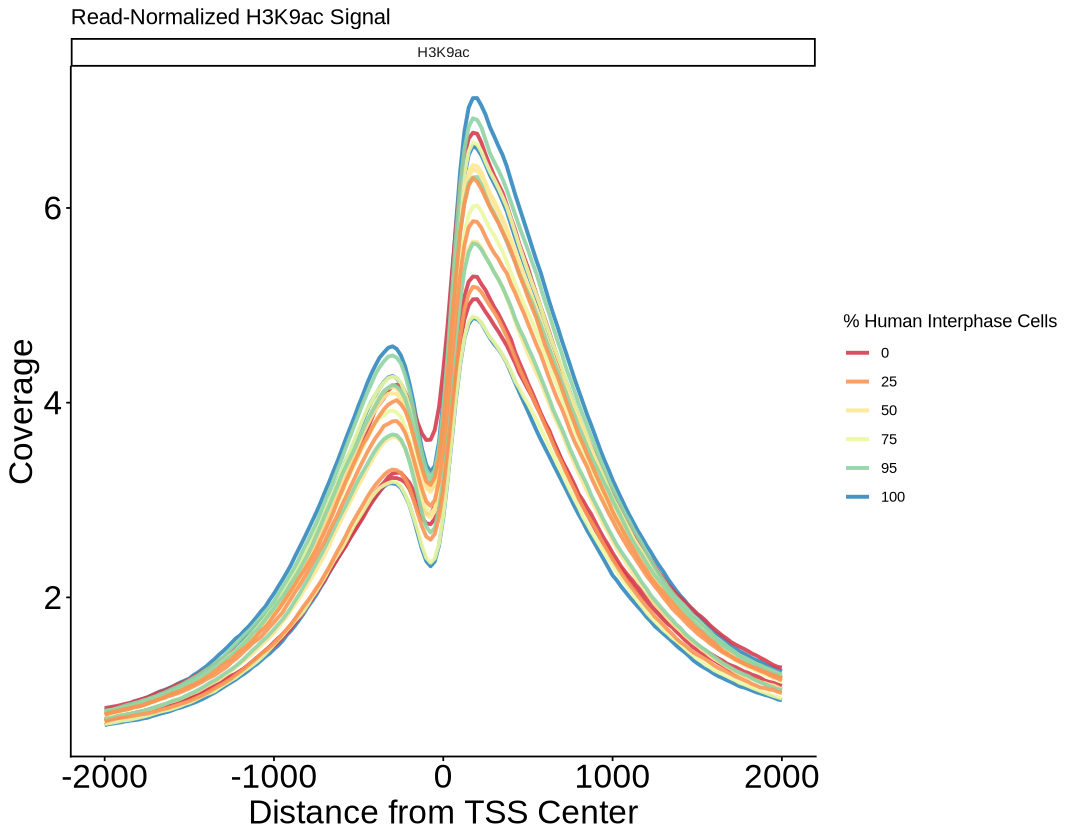

In [73]:
options(repr.plot.width = 9, repr.plot.height = 7)

hist_tss_hg38_LP78_long_ordered <- hist_tss_hg38_LP78_long_ordered %>%
  mutate(biorep_num = factor(biorep_num, levels = sort(unique(biorep_num))))

ggplot(hist_tss_hg38_LP78_long_ordered %>% filter(grepl("H3K9ac", Sample))) +
aes(x = Distance_from_tss, y = Coverage,
    group = Sample, color = as.factor(biorep_num)) +
scale_color_manual(
  values = colorRampPalette(brewer.pal(9, "Spectral"))(6)[1:6],
  name = "% Human Interphase Cells") +
geom_line(linewidth = 1.1, alpha = 0.9) +
facet_wrap(~ antibody, ncol = 2) +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20)) +
labs(title = "Read-Normalized H3K9ac Signal", x = "Distance from TSS Center")

## Supplemental and ReadMe plots

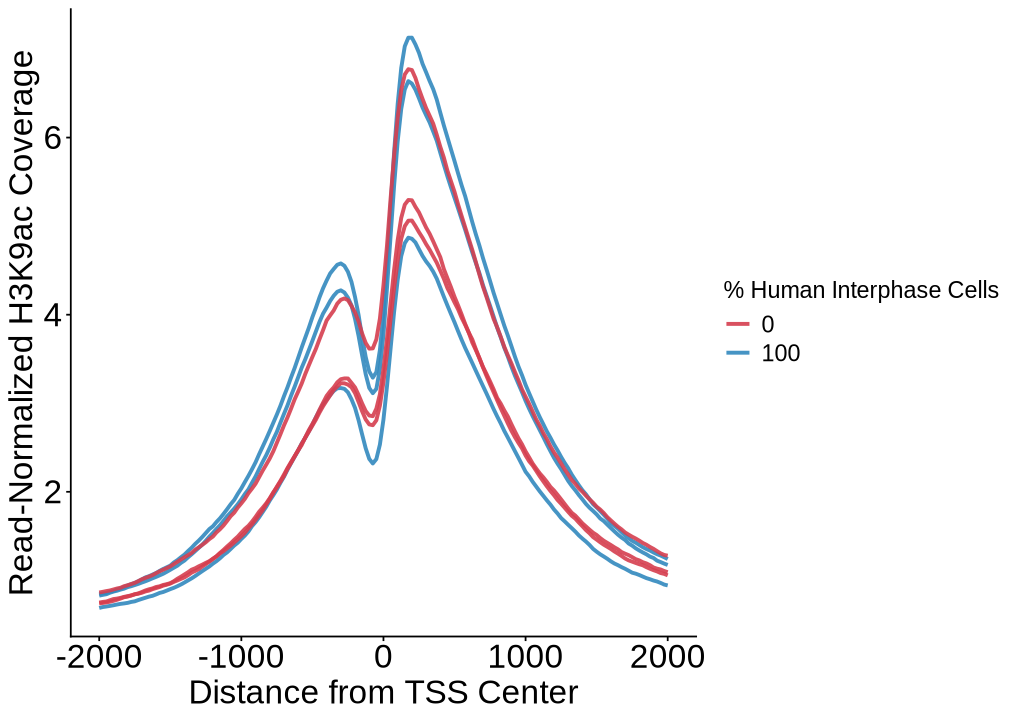

In [336]:
options(repr.plot.width = 8.5, repr.plot.height = 6)
ggplot(
  hist_tss_hg38_LP78_long_ordered %>% 
    filter(grepl("100inter|_0inter", Sample)) %>% 
    filter(grepl("H3K9ac", Sample))
) +
aes(x = Distance_from_tss, y = Coverage,
    group = Sample, color = as.factor(biorep_num)) +
scale_color_manual(
  values = c("#d53e4f", "#3288bd"),
  name = "% Human Interphase Cells"
) +
geom_line(linewidth = 1.1, alpha = 0.9) +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20), 
     legend.title = element_text(size=14),
  legend.text = element_text(size=14)) +
labs(x = "Distance from TSS Center", y = "Read-Normalized H3K9ac Coverage")

In [357]:
hist_tss_hg38_spikenorm_LP78_long %>% 
    filter(grepl("100inter|_0inter", Sample)) %>% 
    filter(grepl("\\_[[:alnum:]].normalized", Sample)) 

Distance_from_tss,Sample,Coverage,cell,treatment,timepoint,biorep,antibody,techrep
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-2000,HelaS3_100sync_0inter_1_H3K9ac_1.normalized.tagdir.Coverage,0.8027825,HelaS3,100sync,0inter,1,H3K9ac,1.normalized.tagdir.Coverage
-2000,HelaS3_100sync_0inter_1_H3K9ac_2.normalized.tagdir.Coverage,0.8150153,HelaS3,100sync,0inter,1,H3K9ac,2.normalized.tagdir.Coverage
-2000,HelaS3_100sync_0inter_1_H3K9ac_3.normalized.tagdir.Coverage,0.7375967,HelaS3,100sync,0inter,1,H3K9ac,3.normalized.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_1.normalized.tagdir.Coverage,3.3726785,HelaS3,0sync,100inter,1,H3K9ac,1.normalized.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_2.normalized.tagdir.Coverage,2.8944512,HelaS3,0sync,100inter,1,H3K9ac,2.normalized.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_3.normalized.tagdir.Coverage,2.8408327,HelaS3,0sync,100inter,1,H3K9ac,3.normalized.tagdir.Coverage
-1975,HelaS3_100sync_0inter_1_H3K9ac_1.normalized.tagdir.Coverage,0.8110426,HelaS3,100sync,0inter,1,H3K9ac,1.normalized.tagdir.Coverage
-1975,HelaS3_100sync_0inter_1_H3K9ac_2.normalized.tagdir.Coverage,0.8211593,HelaS3,100sync,0inter,1,H3K9ac,2.normalized.tagdir.Coverage
-1975,HelaS3_100sync_0inter_1_H3K9ac_3.normalized.tagdir.Coverage,0.7440416,HelaS3,100sync,0inter,1,H3K9ac,3.normalized.tagdir.Coverage


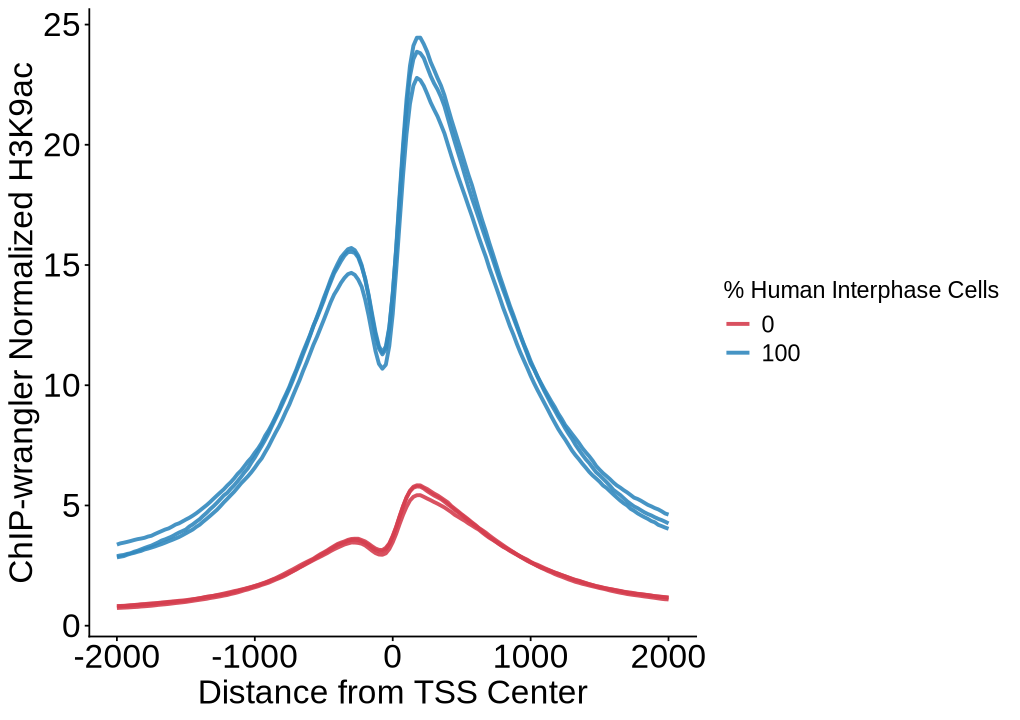

In [360]:
options(repr.plot.width = 8.5, repr.plot.height = 6)
ggplot(
  hist_tss_hg38_spikenorm_LP78_long %>% 
    filter(grepl("100inter|_0inter", Sample)) %>% 
    filter(grepl("\\_[[:alnum:]].normalized", Sample)) 
) +
aes(x = Distance_from_tss, y = Coverage,
    group = Sample, color = as.factor(as.numeric(str_remove(timepoint, "inter")))) +
scale_color_manual(
  values = c("#d53e4f", "#3288bd"),
  name = "% Human Interphase Cells"
) +
geom_line(linewidth = 1.1, alpha = 0.9) +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20), 
     legend.title = element_text(size=14),
  legend.text = element_text(size=14)) +
labs(x = "Distance from TSS Center", y = "ChIP-wrangler Normalized H3K9ac")

In [366]:
hist_tss_hg38_spikenorm_LP78_long <- hist_tss_hg38_spikenorm_LP78_long %>% 
    filter(grepl("100inter|_0inter", Sample)) %>% 
    filter(grepl(".[[:alpha:]]+.normalized", Sample)) %>% 
mutate(
    # detect normalization method
    method = case_when(
      str_detect(Sample, "\\.fly\\.normalized\\.tagdir\\.Coverage$")   ~ "flynorm",
      str_detect(Sample, "\\.yeast\\.normalized\\.tagdir\\.Coverage$") ~ "yeastnorm",
      str_detect(Sample, "\\.normalized\\.tagdir\\.Coverage$")         ~ "norm",
      TRUE ~ "other"
    ),
    
    # remove suffixes to get the base sample name
    base_sample = Sample %>%
      str_remove("\\.fly\\.normalized\\.tagdir\\.Coverage$") %>%
      str_remove("\\.yeast\\.normalized\\.tagdir\\.Coverage$") %>%
      str_remove("\\.normalized\\.tagdir\\.Coverage$"),
    
    # clean techrep column to keep only replicate number
    techrep = str_replace(techrep, "\\..*", "")
  ) %>%
  
  # keep relevant columns and pivot
  select(Distance_from_tss, base_sample, cell, treatment, timepoint, biorep, antibody, techrep, method, Coverage) %>%
  pivot_wider(names_from = method, values_from = Coverage) %>%
  
  # compute confidence and dual normalization metrics
  mutate(
    confidence = abs(flynorm - yeastnorm),
    dualnorm = (flynorm + yeastnorm) / 2
  )

hist_tss_hg38_spikenorm_LP78_formatted <- hist_tss_hg38_spikenorm_LP78_long %>%
  pivot_longer(
    cols = c(flynorm, yeastnorm),
    names_to = "spike.in",
    values_to = "Normalized.Coverage"
  )

In [371]:
head(hist_tss_hg38_spikenorm_LP78_formatted)

Distance_from_tss,base_sample,cell,treatment,timepoint,biorep,antibody,techrep,confidence,dualnorm,spike.in,Normalized.Coverage
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
-2000,HelaS3_100sync_0inter_1_H3K9ac_1,HelaS3,100sync,0inter,1,H3K9ac,1,0.000000000,0.8027825,flynorm,0.8027825
-2000,HelaS3_100sync_0inter_1_H3K9ac_1,HelaS3,100sync,0inter,1,H3K9ac,1,0.000000000,0.8027825,yeastnorm,0.8027825
-2000,HelaS3_100sync_0inter_1_H3K9ac_2,HelaS3,100sync,0inter,1,H3K9ac,2,0.012635897,0.8150153,flynorm,0.8213333
-2000,HelaS3_100sync_0inter_1_H3K9ac_2,HelaS3,100sync,0inter,1,H3K9ac,2,0.012635897,0.8150153,yeastnorm,0.8086974
-2000,HelaS3_100sync_0inter_1_H3K9ac_3,HelaS3,100sync,0inter,1,H3K9ac,3,0.006585685,0.7408895,flynorm,0.7375967
-2000,HelaS3_100sync_0inter_1_H3K9ac_3,HelaS3,100sync,0inter,1,H3K9ac,3,0.006585685,0.7408895,yeastnorm,0.7441824


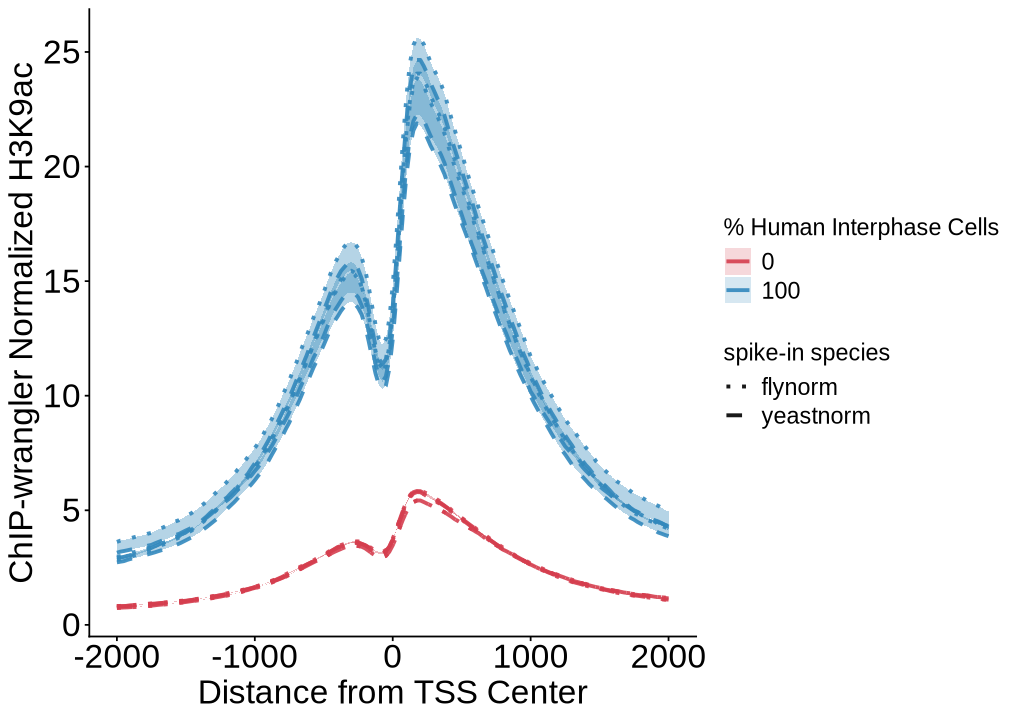

In [379]:
ggplot(hist_tss_hg38_spikenorm_LP78_formatted) +
aes(x = Distance_from_tss,
    group = interaction(base_sample, spike.in), color = as.factor(as.numeric(str_remove(timepoint, "inter")))) +
geom_line(aes(linetype = spike.in, y = Normalized.Coverage), linewidth = 1.1, alpha = 0.9) +
geom_ribbon(
      aes(ymin = dualnorm - (confidence / 2), ymax = dualnorm + (confidence / 2),
        fill = as.factor(as.numeric(str_remove(timepoint, "inter"))),
        group = interaction(base_sample, spike.in)
      ), alpha = 0.2, color = NA ) +
scale_color_manual(
  values = c("#d53e4f", "#3288bd"),
  name = "% Human Interphase Cells") +
scale_fill_manual(
  values = c("#d53e4f", "#3288bd"),
  name = "% Human Interphase Cells") +
scale_linetype_manual(
  values = c("dotted", "dashed"),
  name = "spike-in species") +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20), 
     legend.title = element_text(size=14),
  legend.text = element_text(size=14)) +
labs(x = "Distance from TSS Center", y = "ChIP-wrangler Normalized H3K9ac")

In [229]:
head(hist_tss_dm6_LP78_long)

Distance_from_tss,Sample,Coverage,cell,treatment,timepoint,biorep,antibody,techrep
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-2000,HelaS3_0sync_100inter_1_H3K9ac_1.dm6.tagdir.Coverage,10.402503,HelaS3,0sync,100inter,1,H3K9ac,1.dm6.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_2.dm6.tagdir.Coverage,10.642116,HelaS3,0sync,100inter,1,H3K9ac,2.dm6.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_3.dm6.tagdir.Coverage,10.622783,HelaS3,0sync,100inter,1,H3K9ac,3.dm6.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_input_1.dm6.tagdir.Coverage,9.156727,HelaS3,0sync,100inter,1,input,1.dm6.tagdir.Coverage
-2000,HelaS3_100sync_0inter_1_H3K9ac_1.dm6.tagdir.Coverage,10.460640,HelaS3,100sync,0inter,1,H3K9ac,1.dm6.tagdir.Coverage
-2000,HelaS3_100sync_0inter_1_H3K9ac_2.dm6.tagdir.Coverage,10.545265,HelaS3,100sync,0inter,1,H3K9ac,2.dm6.tagdir.Coverage


svg 
  3

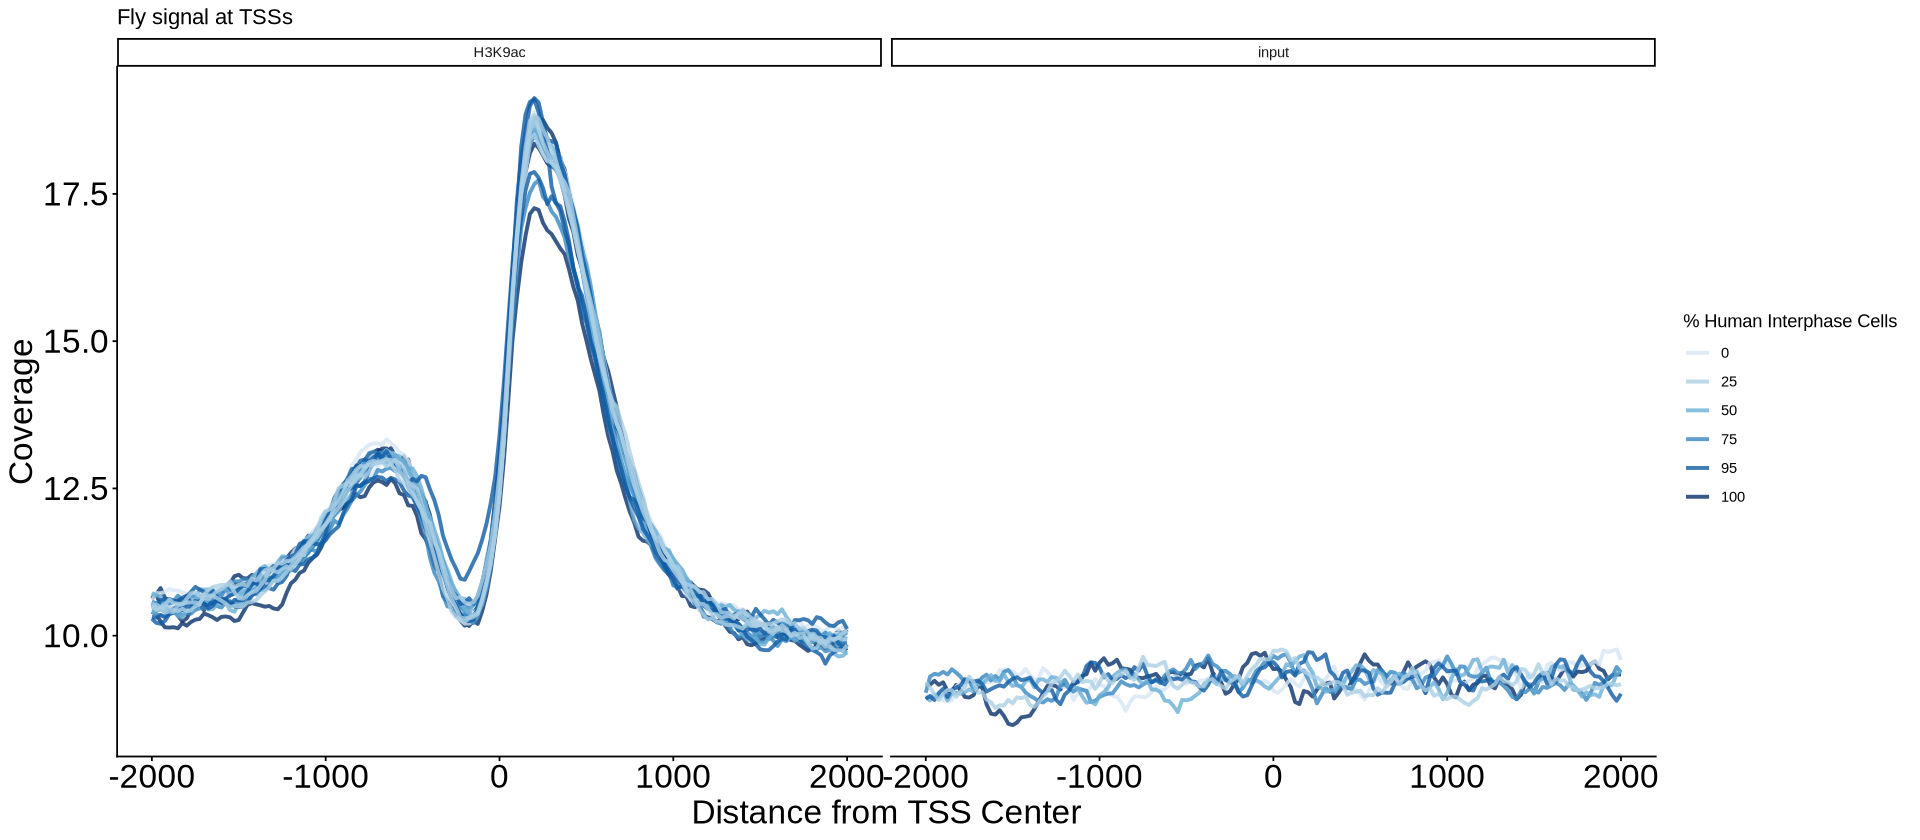

In [231]:
options(repr.plot.width = 16, repr.plot.height = 7)

LP78_hist_tss_dm6 <- ggplot(hist_tss_dm6_LP78_long %>% 
                            arrange((as.factor(as.numeric(str_remove(timepoint, "inter"))))) %>% 
                            filter(grepl("Hela", Sample))) + 
aes(x = Distance_from_tss, y = Coverage, 
    group= Sample, color = as.factor(as.numeric(str_remove(timepoint, "inter")))) +
  scale_color_manual(
      values = colorRampPalette(brewer.pal(9, "Blues"))(7)[2:7],
      name = "% Human Interphase Cells") +
geom_line(linewidth = 1.1, alpha = 0.8) + 
facet_wrap(~ antibody) + 
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20)) +
labs(title = "Fly signal at TSSs", x = "Distance from TSS Center")

# Open SVG device (base R)
#svg("LP78_hist_tss_dm6.svg", width = 16, height = 7)

# Print the ggplot
print(LP78_hist_tss_dm6) 

# Close the device to save the file
dev.off()

svg 
  3

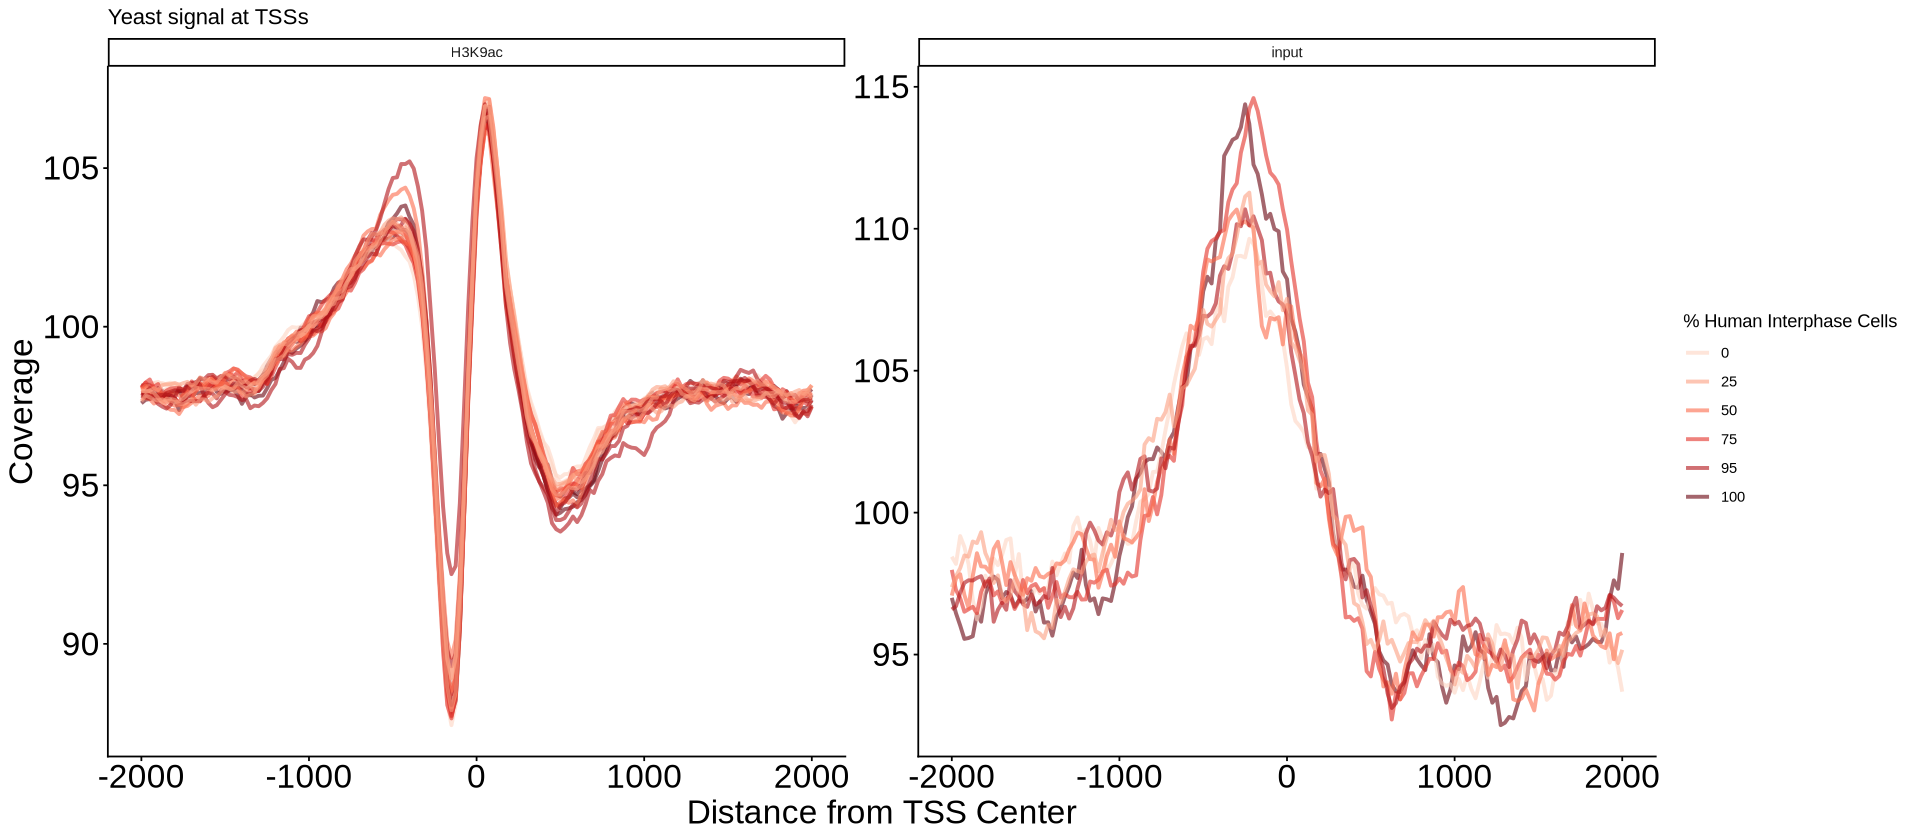

In [232]:
options(repr.plot.width = 16, repr.plot.height = 7)
LP78_hist_tss_sac3 <- ggplot(hist_tss_sac3_LP78_long %>% 
       arrange((as.factor(as.numeric(str_remove(timepoint, "inter"))))) %>% 
       filter(grepl("Hela", Sample))) + 
aes(x = Distance_from_tss, y = Coverage, 
    group= Sample, color = as.factor(as.numeric(str_remove(timepoint, "inter")))) +
  scale_color_manual(
      values = colorRampPalette(brewer.pal(9, "Reds"))(7)[2:7],
      name = "% Human Interphase Cells") +
geom_line(linewidth = 1.1, alpha = 0.6) + 
facet_wrap(~ antibody, scales = "free") + 
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20)) +
labs(title = "Yeast signal at TSSs", x = "Distance from TSS Center")

# Open SVG device (base R)
#svg("LP78_hist_tss_sac3.svg", width = 16, height = 7)

# Print the ggplot
print(LP78_hist_tss_sac3) 

# Close the device to save the file
dev.off()

In [68]:
head(hist_peaks_hg38_norm_LP78_long)

Distance_from_tss,Sample,Coverage,cell,treatment,timepoint,biorep,antibody,techrep
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-2000,hg38_normalized_tagdirs.HelaS3_0sync_100inter_1_H3K9ac_1.fly.normalized.tagdir.Coverage,5.096398,tagdirs.HelaS3,0sync,100inter,1,H3K9ac,1.fly.normalized.tagdir.Coverage
-2000,hg38_normalized_tagdirs.HelaS3_0sync_100inter_1_H3K9ac_1.normalized.tagdir.Coverage,4.747112,tagdirs.HelaS3,0sync,100inter,1,H3K9ac,1.normalized.tagdir.Coverage
-2000,hg38_normalized_tagdirs.HelaS3_0sync_100inter_1_H3K9ac_1.yeast.normalized.tagdir.Coverage,4.429580,tagdirs.HelaS3,0sync,100inter,1,H3K9ac,1.yeast.normalized.tagdir.Coverage
-2000,hg38_normalized_tagdirs.HelaS3_0sync_100inter_1_H3K9ac_2.fly.normalized.tagdir.Coverage,4.146729,tagdirs.HelaS3,0sync,100inter,1,H3K9ac,2.fly.normalized.tagdir.Coverage
-2000,hg38_normalized_tagdirs.HelaS3_0sync_100inter_1_H3K9ac_2.normalized.tagdir.Coverage,4.214988,tagdirs.HelaS3,0sync,100inter,1,H3K9ac,2.normalized.tagdir.Coverage
-2000,hg38_normalized_tagdirs.HelaS3_0sync_100inter_1_H3K9ac_2.yeast.normalized.tagdir.Coverage,4.249118,tagdirs.HelaS3,0sync,100inter,1,H3K9ac,2.yeast.normalized.tagdir.Coverage


## Fig 1c - ChIP-wrangler normalized histogram

In [74]:
hist_peaks_spikenorm_wide <- hist_peaks_hg38_norm_LP78_long %>%
  mutate(
    # detect normalization method
    method = case_when(
      str_detect(Sample, "\\.fly\\.normalized\\.tagdir\\.Coverage$")   ~ "flynorm",
      str_detect(Sample, "\\.yeast\\.normalized\\.tagdir\\.Coverage$") ~ "yeastnorm",
      str_detect(Sample, "\\.normalized\\.tagdir\\.Coverage$")         ~ "norm",
      TRUE ~ "other"
    ),
    
    # remove suffixes to get the base sample name
    base_sample = Sample %>%
      str_remove("\\.fly\\.normalized\\.tagdir\\.Coverage$") %>%
      str_remove("\\.yeast\\.normalized\\.tagdir\\.Coverage$") %>%
      str_remove("\\.normalized\\.tagdir\\.Coverage$"),
    
    # clean techrep column to keep only replicate number
    techrep = str_replace(techrep, "\\..*", "")
  ) %>%
  
  # keep relevant columns and pivot
  select(Distance_from_tss, base_sample, cell, treatment, timepoint, biorep, antibody, techrep, method, Coverage) %>%
  pivot_wider(names_from = method, values_from = Coverage) %>%
  
  # compute confidence and dual normalization metrics
  mutate(
    confidence = abs(flynorm - yeastnorm),
    dualnorm = (flynorm + yeastnorm) / 2
  )

hist_peaks_spikenorm_formatted <- hist_peaks_spikenorm_wide %>%
  pivot_longer(
    cols = c(flynorm, yeastnorm),
    names_to = "spike.in",
    values_to = "Normalized.Coverage"
  )

In [77]:
head(hist_peaks_hg38_readnorm_LP78_long)

Distance_from_tss,Sample,Coverage,cell,treatment,timepoint,biorep,antibody,techrep
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-2000,HelaS3_0sync_100inter_1_H3K9ac_1.hg38.GCcheck.tagdir.Coverage,0.9684744,HelaS3,0sync,100inter,1,H3K9ac,1.hg38.GCcheck.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_2.hg38.GCcheck.tagdir.Coverage,1.2286606,HelaS3,0sync,100inter,1,H3K9ac,2.hg38.GCcheck.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_H3K9ac_3.hg38.GCcheck.tagdir.Coverage,1.1798398,HelaS3,0sync,100inter,1,H3K9ac,3.hg38.GCcheck.tagdir.Coverage
-2000,HelaS3_0sync_100inter_1_input_1.hg38.GCcheck.tagdir.Coverage,0.4542291,HelaS3,0sync,100inter,1,input,1.hg38.GCcheck.tagdir.Coverage
-2000,HelaS3_100sync_0inter_1_H3K9ac_1.hg38.GCcheck.tagdir.Coverage,1.0732687,HelaS3,100sync,0inter,1,H3K9ac,1.hg38.GCcheck.tagdir.Coverage
-2000,HelaS3_100sync_0inter_1_H3K9ac_2.hg38.GCcheck.tagdir.Coverage,1.0459199,HelaS3,100sync,0inter,1,H3K9ac,2.hg38.GCcheck.tagdir.Coverage


In [80]:
hist_peaks_hg38_readnorm_wide <- hist_peaks_hg38_readnorm_LP78_long %>%
  mutate(
    # detect normalization method
    method = case_when(
      str_detect(Sample, "\\.GCcheck\\.tagdir\\.Coverage$")   ~ "readnorm",
      TRUE ~ "other"
    ),
    
    # remove suffixes to get the base sample name
    base_sample = Sample %>%
      str_remove("\\.hg38\\.GCcheck\\.tagdir\\.Coverage$"),
    
    # clean techrep column to keep only replicate number
    techrep = str_replace(techrep, "\\..*", "")
  ) %>%
  
  # keep relevant columns and pivot
  select(Distance_from_tss, base_sample, cell, treatment, timepoint, biorep, antibody, techrep, method, Coverage) %>%
  pivot_wider(names_from = method, values_from = Coverage)


In [81]:
head(hist_peaks_hg38_readnorm_wide)

Distance_from_tss,base_sample,cell,treatment,timepoint,biorep,antibody,techrep,readnorm
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
-2000,HelaS3_0sync_100inter_1_H3K9ac_1,HelaS3,0sync,100inter,1,H3K9ac,1,0.9684744
-2000,HelaS3_0sync_100inter_1_H3K9ac_2,HelaS3,0sync,100inter,1,H3K9ac,2,1.2286606
-2000,HelaS3_0sync_100inter_1_H3K9ac_3,HelaS3,0sync,100inter,1,H3K9ac,3,1.1798398
-2000,HelaS3_0sync_100inter_1_input_1,HelaS3,0sync,100inter,1,input,1,0.4542291
-2000,HelaS3_100sync_0inter_1_H3K9ac_1,HelaS3,100sync,0inter,1,H3K9ac,1,1.0732687
-2000,HelaS3_100sync_0inter_1_H3K9ac_2,HelaS3,100sync,0inter,1,H3K9ac,2,1.0459199


In [103]:
plot_histograms_normalized_stdcurve <- function(input_df, brewer_cols = 9) {
    
  xvar <- "Distance_from_tss"
  condition_num <- length(unique(input_df$timepoint))
  antibody_name <- unique(input_df$antibody)
  cell_name <- unique(input_df$cell)

  # Safeguard palette size (Spectral has max 11)
  brewer_cols <- min(as.numeric(brewer_cols), 11)

  ggplot(input_df, aes(x = Distance_from_tss)) +
    geom_ribbon(
      aes(ymin = dualnorm - (confidence / 2), ymax = dualnorm + (confidence / 2),
        fill = as.factor(as.numeric(str_remove(timepoint, "inter"))),
        group = interaction(base_sample, spike.in)
      ), alpha = 0.3, color = NA ) +
    geom_line(aes(y = Normalized.Coverage, linetype = spike.in,
        color = as.factor(as.numeric(str_remove(timepoint, "inter"))),
        group = interaction(base_sample, spike.in)
      ), linewidth = 1.1 ) +
    labs(
      title = paste("Histogram of", antibody_name, "in", cell_name),
      x = xvar, y = "Normalized Coverage") +
    scale_color_manual(
      values = colorRampPalette(brewer.pal(brewer_cols, "Spectral"))(condition_num),
      name = "% Interphase (Human)",
      labels = as.numeric(unique(str_remove(hist_peaks_spikenorm_formatted$timepoint, "inter"))))  +
    scale_linetype_manual(
      values = c("dotted","dashed"),
      name = "Spike-in species",
      labels = unique(input_df$spike.in))  +
    scale_fill_manual(
      values = colorRampPalette(brewer.pal(brewer_cols, "Spectral"))(condition_num),
      guide = "none") +
    theme_classic() +
    theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20),
      legend.text = element_text(size = 18), legend.title = element_text(size = 20),
      legend.background = element_rect(size = 0.7, linetype = "solid", colour = "grey20"),
      legend.position = "right"
    )
}


In [319]:
as.factor(as.numeric(unique(str_remove(hist_peaks_spikenorm_formatted$timepoint, "inter"))))

[1] 100 0   75  50  95  25 
Levels: 0 25 50 75 95 100

In [155]:
head(genecov_wide)

Distance_from_tss,base_sample,cell,treatment,timepoint,biorep,antibody,techrep,flynorm,norm,yeastnorm,confidence,dualnorm
<int>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-2000,HelaS3_0sync_100inter_1_H3K9ac_1,HelaS3,0sync,100,1,H3K9ac,1,5.096398,4.747112,4.429580,0.666818459,4.762989
-2000,HelaS3_0sync_100inter_1_H3K9ac_2,HelaS3,0sync,100,1,H3K9ac,2,4.146729,4.214988,4.249118,0.102388381,4.197924
-2000,HelaS3_0sync_100inter_1_H3K9ac_3,HelaS3,0sync,100,1,H3K9ac,3,4.241046,4.049720,3.890283,0.350763176,4.065664
-2000,HelaS3_100sync_0inter_1_H3K9ac_1,HelaS3,100sync,0,1,H3K9ac,1,1.150621,1.150621,1.150621,0.000000000,1.150621
-2000,HelaS3_100sync_0inter_1_H3K9ac_2,HelaS3,100sync,0,1,H3K9ac,2,1.162133,1.153194,1.144254,0.017878972,1.153194
-2000,HelaS3_100sync_0inter_1_H3K9ac_3,HelaS3,100sync,0,1,H3K9ac,3,1.087520,1.087520,1.097230,0.009710002,1.092375


In [156]:
levels(hist_peaks_spikenorm_wide$timepoint)

[1] "0"   "25"  "50"  "75"  "95"  "100"

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


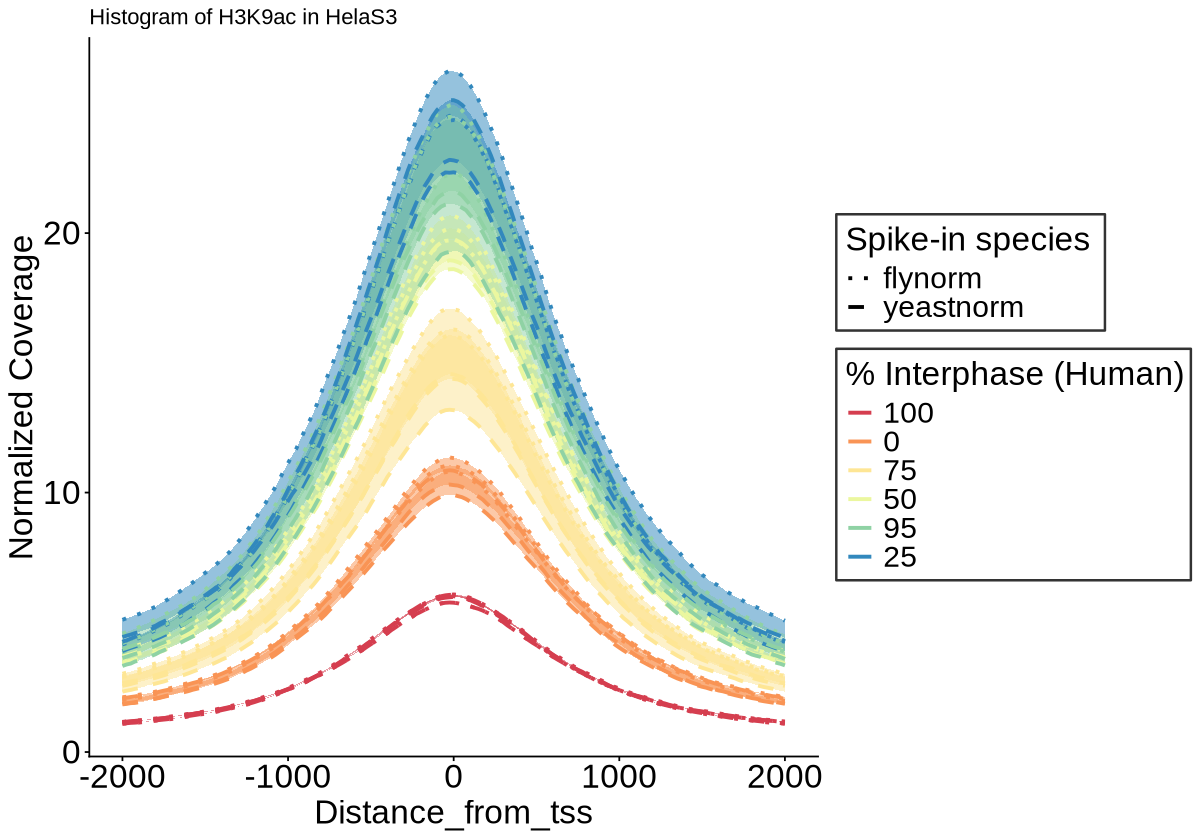

In [104]:
options(repr.plot.width = 10, repr.plot.height = 7)

plot_histograms_normalized_stdcurve(hist_peaks_spikenorm_formatted)

In [237]:
head(hist_peaks_hg38_norm_LP78_long)

Distance_from_tss,Sample,Coverage,cell,treatment,timepoint,biorep,antibody,techrep,method,base_sample
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-2000,HelaS3_0sync_100inter_1_H3K9ac_1.fly.normalized.tagdir.Coverage,5.096398,HelaS3,0sync,100inter,1,H3K9ac,1,flynorm,HelaS3_0sync_100inter_1_H3K9ac_1
-2000,HelaS3_0sync_100inter_1_H3K9ac_1.normalized.tagdir.Coverage,4.747112,HelaS3,0sync,100inter,1,H3K9ac,1,norm,HelaS3_0sync_100inter_1_H3K9ac_1
-2000,HelaS3_0sync_100inter_1_H3K9ac_1.yeast.normalized.tagdir.Coverage,4.429580,HelaS3,0sync,100inter,1,H3K9ac,1,yeastnorm,HelaS3_0sync_100inter_1_H3K9ac_1
-2000,HelaS3_0sync_100inter_1_H3K9ac_2.fly.normalized.tagdir.Coverage,4.146729,HelaS3,0sync,100inter,1,H3K9ac,2,flynorm,HelaS3_0sync_100inter_1_H3K9ac_2
-2000,HelaS3_0sync_100inter_1_H3K9ac_2.normalized.tagdir.Coverage,4.214988,HelaS3,0sync,100inter,1,H3K9ac,2,norm,HelaS3_0sync_100inter_1_H3K9ac_2
-2000,HelaS3_0sync_100inter_1_H3K9ac_2.yeast.normalized.tagdir.Coverage,4.249118,HelaS3,0sync,100inter,1,H3K9ac,2,yeastnorm,HelaS3_0sync_100inter_1_H3K9ac_2


In [113]:
hist_peaks_spikenorm_wide <- hist_peaks_spikenorm_wide %>% mutate(timepoint_clean = as.factor(as.numeric(str_remove(timepoint, "inter")))) 

In [118]:
unique(hist_peaks_spikenorm_wide$timepoint_clean)

[1] 100 0   75  50  95  25 
Levels: 0 25 50 75 95 100

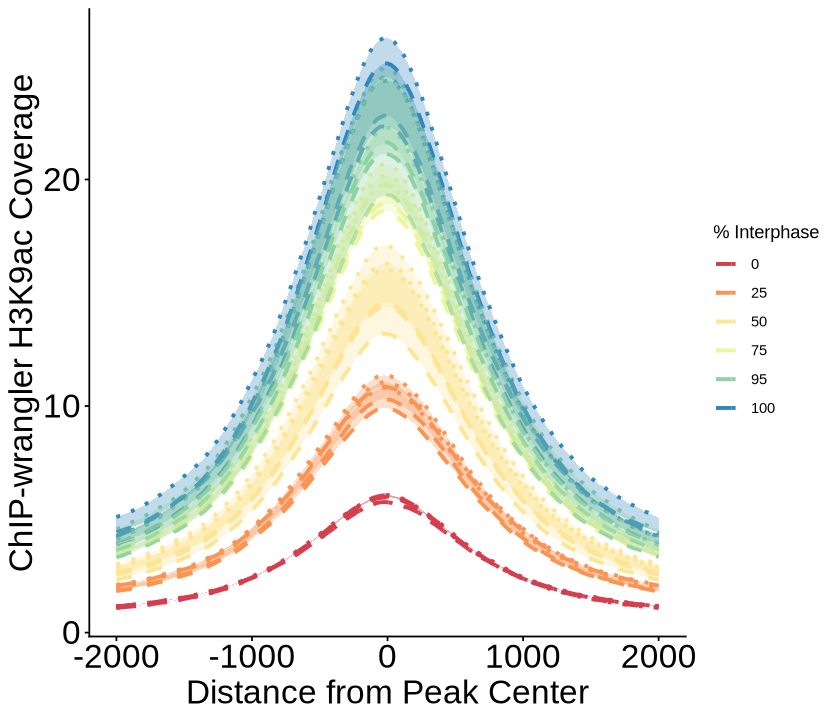

In [122]:
options(repr.plot.width = 7, repr.plot.height = 6)

ggplot(hist_peaks_spikenorm_wide) + 
aes(x = Distance_from_tss, group = base_sample, 
   color = timepoint_clean, fill = timepoint_clean) + 
geom_line(aes(y = flynorm), linetype = "dotted", linewidth = 1.1) + 
geom_line(aes(y = yeastnorm), linetype = "dashed", linewidth = 1.1) + 
geom_ribbon(aes(ymin = dualnorm - 0.5*confidence, 
        ymax = dualnorm + 0.5*confidence, 
        fill = timepoint_clean), alpha = 0.3, color = NA) +
scale_color_manual(
      values = colorRampPalette(
        brewer.pal(9, "Spectral")
      )(6 )[(1):(6)],
      name = "% Interphase") +
scale_fill_manual(
      values = colorRampPalette(
        brewer.pal(9, "Spectral")
      )(6 )[(1):(6)],
      guide = "none") +
theme(axis.text = element_text(size=20), 
        axis.title=element_text(size=20)) + 
labs(x = "Distance from Peak Center", y = "ChIP-wrangler H3K9ac Coverage")

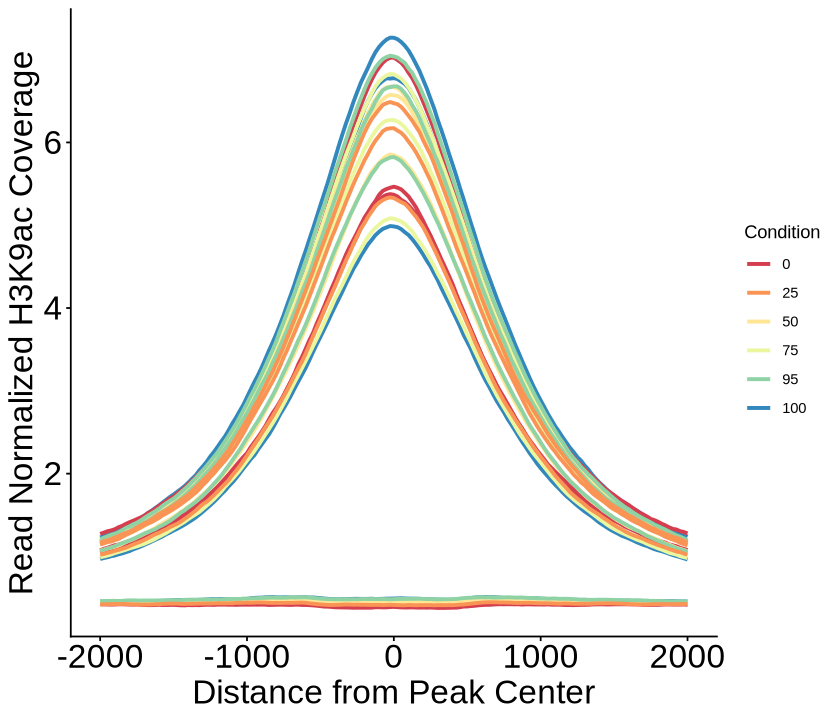

In [123]:
ggplot(hist_peaks_hg38_readnorm_wide) + 
aes(x = Distance_from_tss, group = base_sample, 
   color = as.factor(as.numeric(str_remove(timepoint, "inter")))) + 
geom_line(aes(y = readnorm), linewidth = 1.1) + 
scale_color_manual(
      values = colorRampPalette(
        brewer.pal(9, "Spectral")
      )(6 )[(1):(6)],
      name = "Condition",
      labels = aes(as.factor(timepoint))
    ) +
theme(axis.text = element_text(size=20), 
        axis.title=element_text(size=20)) + 
labs(x = "Distance from Peak Center", y = "Read Normalized H3K9ac Coverage")

## Fig 1d - Standard Curve

In [144]:
histograms_signalarea_stdcurve <- function(input_df, base_sample, dualnorm, colname1) {
  # ensym() converts strings into symbols, so function inputs can be understood
  ### within ggplot
  base_sample <- rlang::ensym(base_sample)
  dualnorm <- rlang::ensym(dualnorm)
  colname1 <- rlang::ensym(colname1)
  # get a list of unique sample names
  samples <- unique(input_df$base_sample)

  # make sure first column is named properly
  colnames(input_df)[1] <- "Distance_from_center"

  # get x variable
  x <- unique(input_df[[1]])

  # initialize empty matrix, then use to make dataframe output
  AUC_peaks <- matrix(data = "", nrow = length(samples), ncol = 1)
  AUC_peaks_df <- data.frame(AUC_peaks, row.names = samples)

  # fill in AUC dataframe for each sample
  for (i in 1:length(samples)) {

    y <- input_df |>
      dplyr::filter(base_sample == samples[i]) |>
      dplyr::select(dualnorm)
    y <- dplyr::pull(y, dualnorm)

    AUC_peaks_df[i, ] <- DescTools::AUC(x, y, method = c("trapezoid"))

  }
 # uncomment below if this stops working
  #AUC_peaks_df

  # get data in numeric form
  AUC_peaks_df <- as.data.frame(sapply(AUC_peaks_df, as.numeric))
  #now get this also as an output:
  AUC_peaks_df

  # add in the treatment column for plotting
  treatment_df <- input_df |>
    dplyr::filter(Distance_from_center == "-2000") |>
    dplyr::select(timepoint)

  treatment_vect <- dplyr::pull(treatment_df, timepoint)
  treatment_vect <- str_remove(treatment_vect, "inter")
 # QC the treatment_vect
#  print(treatment_vect)

  # plot signal area
  ## first make colors vector
  color_vect <- unique(treatment_vect)

  # graph labels in title custom
  cell_type <- unique(input_df[[3]])
  AUC_name <- colnames(AUC_peaks_df[1])

  # plot
    AUC_peaks_df |>
    ggplot2::ggplot(ggplot2::aes(x = as.numeric(treatment_vect), 
                                 color = as.factor(as.numeric(treatment_vect)),
                                y = AUC_peaks)) +
    ggplot2::geom_point(size = 5, alpha = 0.7) +
    ggplot2::scale_color_manual(
      values = colorRampPalette(RColorBrewer::brewer.pal(9, "Spectral"))(6)[1:6],
      name = "Condition") +
    ggplot2::theme_classic() +
    ggplot2::labs(title = paste(as.character(AUC_name), "in", as.character(cell_type), "cells"),
         x = "Condition",
         y = "Signal Area")

}

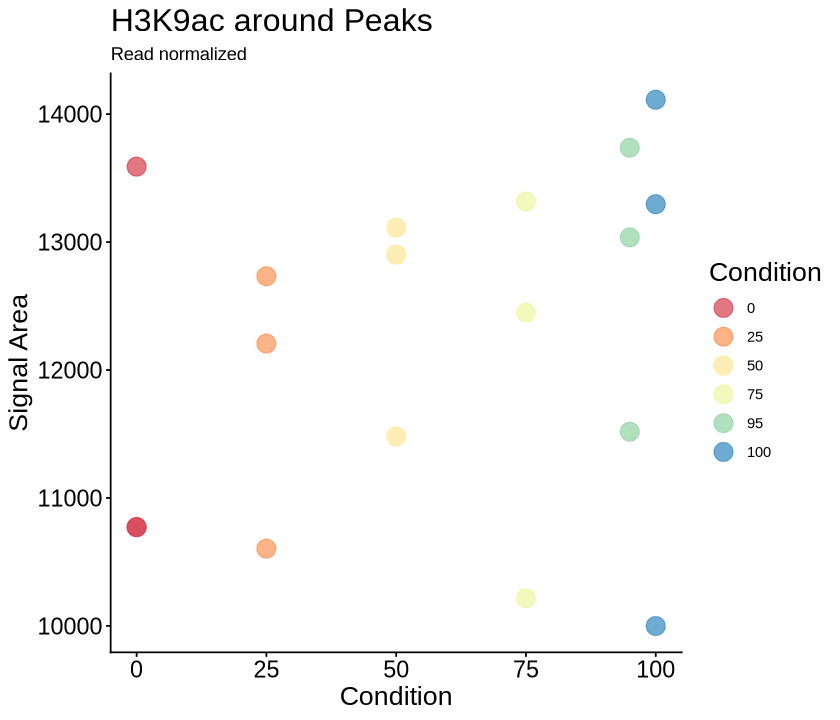

In [151]:
options(repr.plot.width = 7, repr.plot.height = 6)

histograms_signalarea_stdcurve(hist_peaks_hg38_readnorm_wide %>% filter(grepl("K9ac", base_sample)), 
                               dualnorm = readnorm, colname1 = colname1) + 
  labs(title = "H3K9ac around Peaks", 
       subtitle = "Read normalized") + 
theme(title = element_text(size = 16), 
      axis.text = element_text(size = 14), axis.title = element_text(size = 16),
     strip.text = element_text(size = 14))

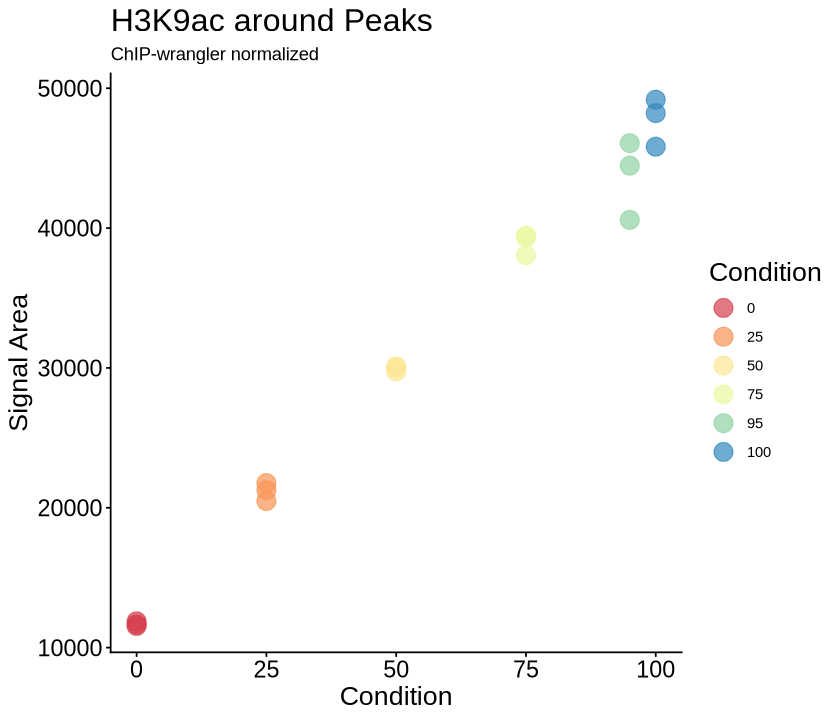

In [150]:
options(repr.plot.width = 7, repr.plot.height = 6)

histograms_signalarea_stdcurve(hist_peaks_spikenorm_wide, colname1 = colname1) + 
  labs(title = "H3K9ac around Peaks", 
       subtitle = "ChIP-wrangler normalized") + 
theme(title = element_text(size = 16), 
      axis.text = element_text(size = 14), axis.title = element_text(size = 16),
     strip.text = element_text(size = 14))

## Fig 1e - H3K9ac titration scatterplots

In [79]:
counts_chr19_hg38_LP78_avg <- counts_chr19_hg38_LP78 %>%
  # Pivot longer: collect all tag columns
  pivot_longer(
    cols = ends_with(".Tag"),
    names_to = "SampleColumn",
    values_to = "TagValue"
  ) %>%
  
  # Extract normalization type
  mutate(
    Normalization = case_when(
      str_detect(SampleColumn, "\\.normalized\\.tagdir\\.Tag$") ~ "spike_in",
      str_detect(SampleColumn, "\\.hg38\\.GCcheck\\.tagdir\\.Tag$") ~ "read_depth",
      TRUE ~ NA_character_
    ),
    # remove normalization suffix from name
    Sample = SampleColumn %>%
      str_remove("\\.normalized\\.tagdir\\.Tag$") %>%
      str_remove("\\.hg38\\.GCcheck\\.tagdir\\.Tag$")
  ) %>%
  select(-SampleColumn) %>%
  
  # Extract replicate number (assuming _1/_2/_3)
  mutate(
    Replicate = str_extract(Sample, "_\\d+$"),
    SampleGroup = str_remove(Sample, "_\\d+$")
  ) %>%
  
  # Average technical replicates per Peak × SampleGroup × Normalization
  group_by(across(c(PeakID, Chr, Start, End, Strand, Peak.Score,
                    Focus.Ratio.Region.Size, Annotation, Detailed.Annotation,
                    Distance.to.TSS, Nearest.PromoterID, Entrez.ID,
                    Nearest.Unigene, Nearest.Refseq, Nearest.Ensembl,
                    Gene.Name, Gene.Alias, Gene.Description, Gene.Type,
                    SampleGroup, Normalization))) %>%
  summarise(MeanTag = mean(TagValue, na.rm = TRUE), .groups = "drop") %>%
  
  # Pivot wider: one column per SampleGroup × Normalization
  pivot_wider(
    names_from = c(SampleGroup, Normalization),
    names_glue = "{SampleGroup}.{Normalization}",
    values_from = MeanTag
  )

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


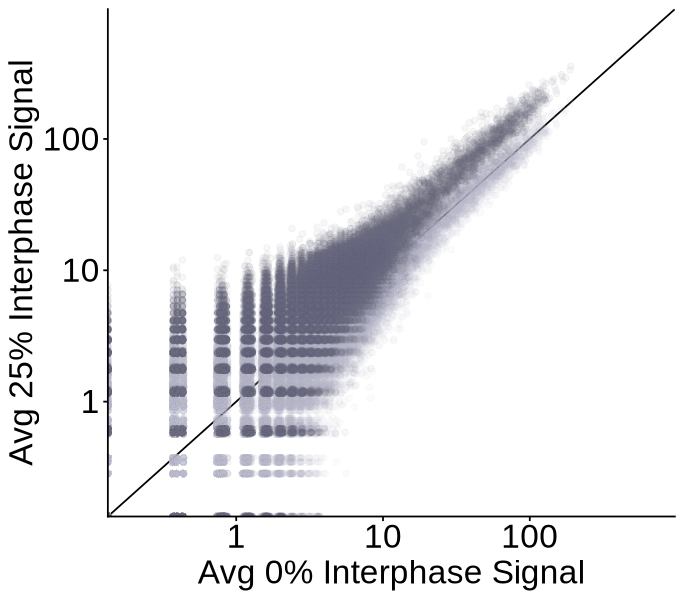

In [394]:
ggplot(counts_chr19_hg38_LP78_avg) + 
geom_abline() +
geom_point(aes(x = HelaS3_100sync_0inter_1_H3K9ac.read_depth, 
    y = HelaS3_75sync_25inter_1_H3K9ac.read_depth), alpha = 0.05, color = "#bdb5c7") + 
geom_point(aes(x = HelaS3_100sync_0inter_1_H3K9ac.spike_in, 
    y = HelaS3_75sync_25inter_1_H3K9ac.spike_in), alpha = 0.05, color = "#746d7d") + 
scale_x_log10() + 
scale_y_log10() + 
coord_cartesian(xlim = c(0.2, 650), ylim = c(0.2, 650)) +
theme(axis.text = element_text(size=20), 
        axis.title=element_text(size=20)) + 
labs(x = "Avg 0% Interphase Signal", y = "Avg 25% Interphase Signal") 

# Figure 2

## QCs for LP85 vs LP88

### nucleotide frequency plots

In [6]:
# get vector of sample tagdir names
dm6_files <- list.files(path = "/home/lahodge/data/experiments/LP_85/dm6_data/dm6_tagdirs_copy/", pattern = "-tagdir")

# initialize output matrix (proper row/col numbers)
basedist_dm6 <- data.frame(matrix(NA, 
                                   nrow = 1000, ncol= (length(dm6_files) + 2)))


for (i in 1:length(dm6_files)) {
  
  # get name of input file, paste0 uses no spaces
  in_file <- paste0("/home/lahodge/data/experiments/LP_85/dm6_data/dm6_tagdirs_copy/", dm6_files[i], "/tagFreqUniq.txt")

  # read each table
  sample_basedist_i <- read.table(in_file, sep="\t", header = T)
  
  colnames(sample_basedist_i)[1] <- "Offset"
  
  # put each sample basedist in tidy format (1 col each)
  sample_basedist_tidyi <- sample_basedist_i %>% 
    pivot_longer(cols = c("A", "C", "G", "T"), 
                 names_to = "Base", 
                 values_to = "Frequency")
  
  # first column is all tag lengths, add one to the output df
  basedist_dm6[,1] <- sample_basedist_tidyi[,1]
  colnames(basedist_dm6)[1] <- "Offset"
  
  # add one base column to output df (same in every sample df)
  basedist_dm6[,2] <- sample_basedist_tidyi["Base"]
  colnames(basedist_dm6)[2] <- "Base"
  
  # add Frequency column from each sample to output df
  basedist_dm6[,i + 2] <- sample_basedist_tidyi["Frequency"]
  
  # give each fraction of tags column a name from the sample
  # str_remove will remove the extra suffixes from tagdir names in files list
  colnames(basedist_dm6)[i + 2] <- str_remove(dm6_files[i], pattern = "_R1_001.concat.dm6-tagdir")
  
}

# need to also remove prefix numbers, will mess up ggplot
names(basedist_dm6) <- gsub("^[[:digit:]]+\\_", "", names(basedist_dm6))

names(basedist_dm6) <- gsub("-", "", names(basedist_dm6))

plot_basedist <- function(basedist_dm6, Offset, Base, Sample) {
  ggplot(data = basedist_dm6) + 
    aes_string(x = Offset, y = Sample, color = Base, group = Base) +
    geom_line(linewidth = 1.1, alpha = 0.8) +
    scale_color_manual(values = c("firebrick", "goldenrod", "mediumseagreen", "steelblue"), 
                       labels = c("A", "C", "G", "T")) +
    labs(y = "Nucleotide Frequency", x = "Distance from Read 5' End") +
    theme(legend.position = c(0.85, 0.5)) + 
    theme(axis.text.x = element_text(size=14),
         axis.title.x = element_text(size = 14),
         axis.text.y = element_text(size=14), 
         axis.title.y = element_text(size=14))
}

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


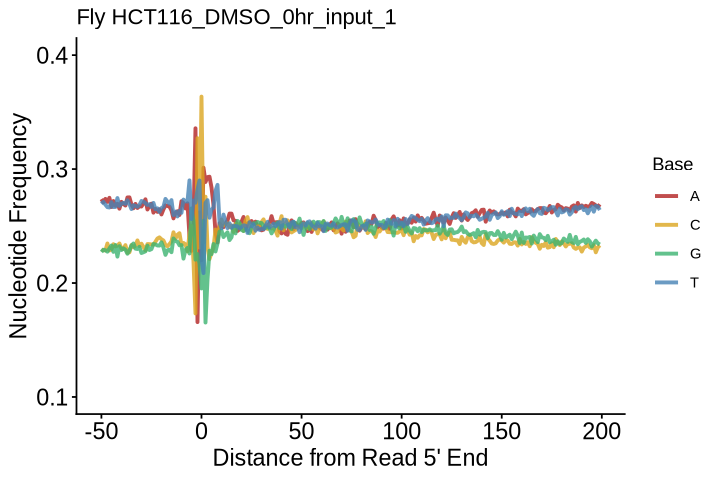

In [7]:
options(repr.plot.width = 6, repr.plot.height = 4)
plot_basedist(basedist_dm6, "Offset", "Base", "HCT116_DMSO_0hr_input_1") + 
labs(title = "Fly HCT116_DMSO_0hr_input_1") +
coord_cartesian(ylim = c(0.1, 0.4)) + 
theme(legend.position = "right")

In [8]:
# get vector of sample tagdir names
hg38_files <- list.files(path = "/home/lahodge/data/experiments/LP_85/hg38_data/hg38_tagdirs_copy/", pattern = "-tagdir")

# initialize output matrix (proper row/col numbers)
basedist_hg38 <- data.frame(matrix(NA, 
                                   nrow = 1000, ncol= (length(hg38_files) + 2)))


for (i in 1:length(hg38_files)) {
  
  # get name of input file, paste0 uses no spaces
  in_file <- paste0("/home/lahodge/data/experiments/LP_85/hg38_data/hg38_tagdirs_copy/", hg38_files[i], "/tagFreqUniq.txt")

  # read each table
  sample_basedist_i <- read.table(in_file, sep="\t", header = T)
  
  colnames(sample_basedist_i)[1] <- "Offset"
  
  # put each sample basedist in tidy format (1 col each)
  sample_basedist_tidyi <- sample_basedist_i %>% 
    pivot_longer(cols = c("A", "C", "G", "T"), 
                 names_to = "Base", 
                 values_to = "Frequency")
  
  # first column is all tag lengths, add one to the output df
  basedist_hg38[,1] <- sample_basedist_tidyi[,1]
  colnames(basedist_hg38)[1] <- "Offset"
  
  # add one base column to output df (same in every sample df)
  basedist_hg38[,2] <- sample_basedist_tidyi["Base"]
  colnames(basedist_hg38)[2] <- "Base"
  
  # add Frequency column from each sample to output df
  basedist_hg38[,i + 2] <- sample_basedist_tidyi["Frequency"]
  
  # give each fraction of tags column a name from the sample
  # str_remove will remove the extra suffixes from tagdir names in files list
  colnames(basedist_hg38)[i + 2] <- str_remove(hg38_files[i], pattern = "_R1_001.concat.hg38-tagdir")
  
}

# need to also remove prefix numbers, will mess up ggplot
names(basedist_hg38) <- gsub("^[[:digit:]]+\\_", "", names(basedist_hg38))

names(basedist_hg38) <- gsub("-", "", names(basedist_hg38))

plot_basedist <- function(basedist, Offset, Base, Sample) {
  ggplot(data = basedist_hg38) + 
    aes_string(x = Offset, y = Sample, color = Base, group = Base) +
    geom_line(linewidth = 1.1, alpha = 0.8) +
    scale_color_manual(values = c("firebrick", "goldenrod", "slateblue", "mediumorchid3"), 
                       labels = c("A", "C", "G", "T")) +
    labs(y = "Nucleotide Frequency", x = "Distance from TSS") +
    theme(legend.position = c(0.85, 0.77)) + 
    theme(axis.text.x = element_text(size=14),
         axis.title.x = element_text(size = 14),
         axis.text.y = element_text(size=14), 
         axis.title.y = element_text(size=14))
}

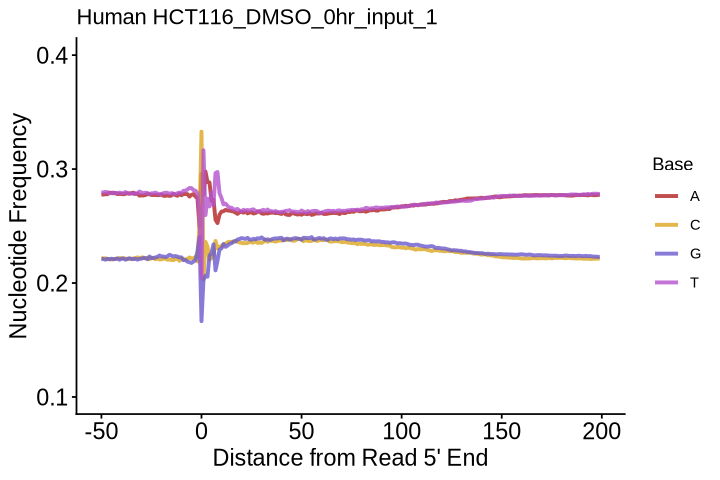

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4)
plot_basedist(basedist, "Offset", "Base", "HCT116_DMSO_0hr_input_1") + 
labs(title = "Human HCT116_DMSO_0hr_input_1", x = "Distance from Read 5' End") +
coord_cartesian(ylim = c(0.1, 0.4)) + 
theme(legend.position = "right")

### overall GC content

In [21]:
extract_gc <- function(path, pattern, genome, suffix_pattern) {
  files <- list.files(path = path, pattern = pattern)
  
  df <- data.frame(Sample = character(), AvgGC = numeric(), Genome = character())
  
  for (f in files) {
    in_file <- file.path(path, f, "tagInfo.txt")
    line10 <- readLines(in_file)[10]
    gc_val <- as.numeric(str_extract(line10, "[0-9\\.]+"))
    
    sample_name <- str_remove(f, suffix_pattern)
    sample_name <- gsub("^[[:digit:]]+\\_", "", sample_name)
    sample_name <- gsub("-", "", sample_name)
    
    df <- rbind(df, data.frame(Sample = sample_name, AvgGC = gc_val, Genome = genome))
  }
  return(df)
}

# extract for each genome
hg38_gc <- extract_gc("/home/lahodge/data/experiments/LP_85/hg38_data/hg38_tagdirs_copy/", "input_1_R1.*-tagdir", 
                      "hg38", "_R1_001.concat.hg38-tagdir")
sac3_gc <- extract_gc("/home/lahodge/data/experiments/LP_85/sac3_data/sac3_tagdirs_copy/", "input_1_R1.*-tagdir", 
                      "sac3", "_R1_001.concat.sac3-tagdir")
dm6_gc  <- extract_gc("/home/lahodge/data/experiments/LP_85/dm6_data/dm6_tagdirs_copy/", "input_1_R1.*-tagdir", 
                      "dm6", "_R1_001.concat.dm6-tagdir")

# combine
gc_content <- bind_rows(hg38_gc, sac3_gc, dm6_gc)

options(repr.plot.width = 6.5, repr.plot.height = 5)
# plot with custom colors
LP85_overall_GCcontent_inputs_plot <- ggplot(gc_content, aes(x = Sample, y = AvgGC, color = Genome)) +
  geom_hline(yintercept = 0.42, color = "grey", alpha = 0.7, linetype = "dashed") + 
  geom_hline(yintercept = 0.409, color = "navyblue", alpha = 0.7, linetype = "dashed") + 
  geom_hline(yintercept = 0.385, color = "firebrick", alpha = 0.7, linetype = "dashed") + 
  geom_point(size = 4) +
  scale_color_manual(values = c(hg38 = "navyblue", sac3 = "firebrick", dm6 = "grey")) +
  labs(y = "Average Fragment GC Content", x = "Sample") +
  theme(base_size = 18,
       axis.text.x = element_text(angle = 45, hjust = 1)) +
coord_cartesian(ylim = c(0.25, 0.5))

In [22]:
genome_gc <- data.frame(
  Genome = c("hg38", "sac3", "dm6"),
  TypicalGC = c(0.409, 0.38, 0.42)  # <-- adjust to the correct reference values
)

df_norm <- gc_content %>%
  left_join(genome_gc, by = "Genome") %>%
  mutate(GC_norm = AvgGC / TypicalGC)

df_norm

Sample,AvgGC,Genome,TypicalGC,GC_norm
<chr>,<dbl>,<chr>,<dbl>,<dbl>
HCT116_DMSO_0hr_input_1,0.463,hg38,0.409,1.132029
HCT116_IAA_1hr_input_1,0.456,hg38,0.409,1.114914
HCT116_IAA_4hr_input_1,0.416,hg38,0.409,1.017115
HCT116_TRP_1hr_input_1,0.458,hg38,0.409,1.119804
HCT116_TRP_4hr_input_1,0.455,hg38,0.409,1.112469
HCT116_DMSO_0hr_input_1,0.409,sac3,0.380,1.076316
HCT116_IAA_1hr_input_1,0.406,sac3,0.380,1.068421
HCT116_IAA_4hr_input_1,0.389,sac3,0.380,1.023684
HCT116_TRP_1hr_input_1,0.406,sac3,0.380,1.068421


In [36]:
extract_gc_stats <- function(path, pattern, suffix_pattern) {
  # List sample folders
  folders <- list.files(path = path, pattern = pattern)
  
  # Initialize results
  df <- data.frame(Sample = character(),
                   Sample_MeanGC = numeric(),
                   Sample_MedianGC = numeric(),
                   Genome_MeanGC = numeric(),
                   Genome_MedianGC = numeric())
  
  # Weighted median function
  weighted_median <- function(gc, pdf) {
    df_tmp <- data.frame(gc = gc, pdf = pdf)
    df_tmp <- df_tmp[order(df_tmp$gc), ]
    df_tmp$cumPDF <- cumsum(df_tmp$pdf) / sum(df_tmp$pdf)
    approx(df_tmp$cumPDF, df_tmp$gc, xout = 0.5)$y
  }
  
  for (f in folders) {
    folder_path <- file.path(path, f)
    
    # Paths to files
    sample_file <- file.path(folder_path, "tagGCcontent.txt")
    genome_file <- file.path(folder_path, "genomeGCcontent.txt")
    
    # Skip if files do not exist
    if (!file.exists(sample_file)) {
      warning(paste("Sample GC file not found:", sample_file))
      next
    }
    if (!file.exists(genome_file)) {
      warning(paste("Genome GC file not found:", genome_file))
      next
    }
    
    # Read files
    sample_gc <- read.table(sample_file, header = TRUE, sep = "\t", 
                            stringsAsFactors = FALSE, check.names = FALSE)
    genome_gc <- read.table(genome_file, header = TRUE, sep = "\t", 
                            stringsAsFactors = FALSE, check.names = FALSE)
    
    # Convert to numeric
    sample_gc$`GC%` <- as.numeric(sample_gc$`GC%`)
    sample_gc$`Normalized Fraction(PDF)` <- as.numeric(sample_gc$`Normalized Fraction(PDF)`)
    genome_gc$`GC%` <- as.numeric(genome_gc$`GC%`)
    genome_gc$`Normalized Fraction(PDF)` <- as.numeric(genome_gc$`Normalized Fraction(PDF)`)
    
    # Drop any NA rows
    sample_gc <- sample_gc[!is.na(sample_gc$`GC%`) & !is.na(sample_gc$`Normalized Fraction(PDF)`), ]
    genome_gc <- genome_gc[!is.na(genome_gc$`GC%`) & !is.na(genome_gc$`Normalized Fraction(PDF)`), ]
    
    # Compute weighted mean
    mean_sample <- sum(sample_gc$`GC%` * sample_gc$`Normalized Fraction(PDF)` / 
                       sum(sample_gc$`Normalized Fraction(PDF)`))
    mean_genome <- sum(genome_gc$`GC%` * genome_gc$`Normalized Fraction(PDF)` / 
                       sum(genome_gc$`Normalized Fraction(PDF)`))
    
    # Compute weighted median
    median_sample <- weighted_median(sample_gc$`GC%`, sample_gc$`Normalized Fraction(PDF)`)
    median_genome <- weighted_median(genome_gc$`GC%`, genome_gc$`Normalized Fraction(PDF)`)
    
    # Clean sample name
    sample_name <- str_remove(f, suffix_pattern)
    sample_name <- gsub("^[[:digit:]]+\\_", "", sample_name)
    sample_name <- gsub("-", "", sample_name)
    
    # Append to results
    df <- rbind(df, data.frame(Sample = sample_name,
                               Sample_MeanGC = mean_sample,
                               Sample_MedianGC = median_sample,
                               Genome_MeanGC = mean_genome,
                               Genome_MedianGC = median_genome))
  }
  
  return(df)
}

hg38_biased_stats <- extract_gc_stats("/home/lahodge/data/experiments/LP_85/hg38_data/hg38_tagdirs_copy/", "input_1_R1_001.*-tagdir", ".concat.hg38-tagdir")
dm6_biased_stats <- extract_gc_stats("/home/lahodge/data/experiments/LP_85/dm6_data/dm6_tagdirs_copy/", "input_1_R1_001.*-tagdir", ".concat.dm6-tagdir")
sac3_biased_stats <- extract_gc_stats("/home/lahodge/data/experiments/LP_85/sac3_data/sac3_tagdirs_copy/", "input_1_R1_001.*-tagdir", ".concat.sac3-tagdir")

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collaps

In [37]:
# Combine results and compute Sample/Genome ratio
all_biased_gc_stats <- bind_rows(
  hg38_biased_stats %>% mutate(Genome = "hg38"),
  dm6_biased_stats %>% mutate(Genome = "dm6"),
  sac3_biased_stats %>% mutate(Genome = "sac3")
) %>%
  mutate(GC_Ratio = Sample_MeanGC / Genome_MeanGC)

# Order samples by GC ratio for readability
all_biased_gc_stats <- all_biased_gc_stats %>%
  mutate(Sample = factor(Sample, levels = unique(Sample[order(GC_Ratio)])))

# Plot
LP85_relative_GCcontent_inputs_plot <- ggplot(all_biased_gc_stats, aes(x = str_remove(Sample, "_input_1_R1_001"), y = GC_Ratio, color = Genome)) +
  geom_point(position = position_dodge(width = 0.6), size = 5) +
  geom_hline(yintercept = 1, linewidth = 1, linetype = "dashed", color = "gray40") +
  labs(
    title = "Sample vs Genome GC Bias Across Species",
    x = "Sample",
    y = "Mean Sample GC / Mean Genome GC"
  ) +
  scale_color_manual(values = c("hg38" = "grey50", "dm6" = "dodgerblue2", "sac3" = "firebrick2")) +
  theme_minimal(base_size = 18) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid.minor = element_blank()
  ) +
coord_cartesian(ylim = c(0.75, 1.25))

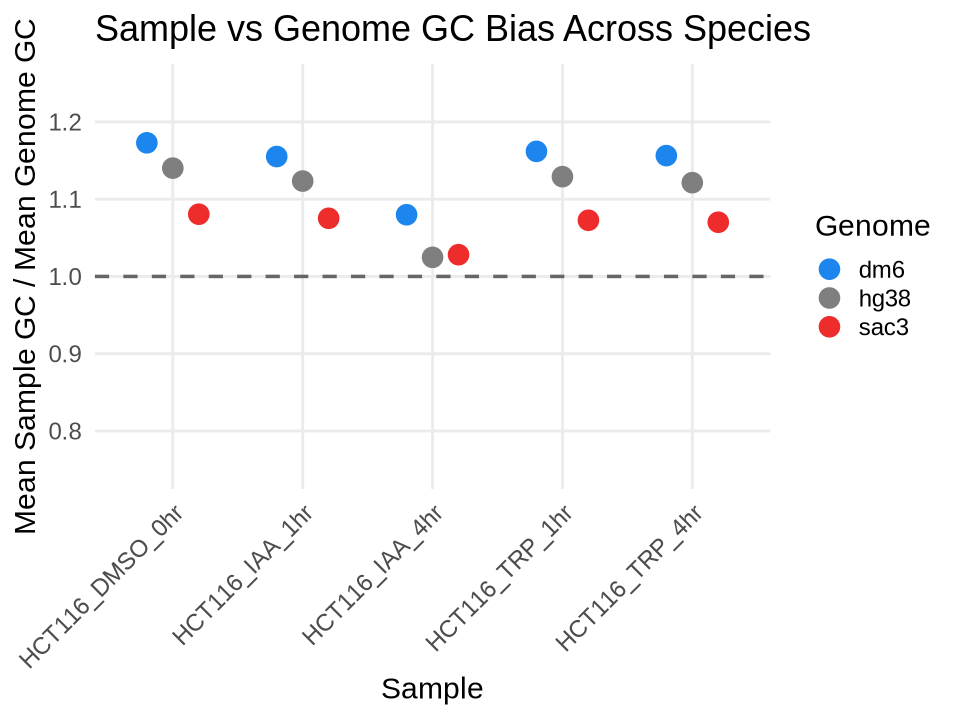

In [38]:
options(repr.plot.width = 8, repr.plot.height = 6)

LP85_relative_GCcontent_inputs_plot

In [39]:
### unbiased samples:

hg38_unbiased_stats <- extract_gc_stats("/home/lahodge/data/experiments/LP_88_combined_fastqs/hg38_data/hg38_tagdirs/",  "input_1.*-tagdir", ".concat.hg38-tagdir")
dm6_unbiased_stats <- extract_gc_stats("/home/lahodge/data/experiments/LP_88_combined_fastqs/dm6_data/dm6_tagdirs/",  "input_1.*-tagdir", ".concat.dm6-tagdir")
sac3_unbiased_stats <- extract_gc_stats("/home/lahodge/data/experiments/LP_88_combined_fastqs/sac3_data/sac3_tagdirs/",  "input_1.*-tagdir", ".concat.sac3-tagdir")

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collaps

In [43]:
# Combine results and compute Sample/Genome ratio
all_unbiased_gc_stats <- bind_rows(
  hg38_unbiased_stats %>% mutate(Genome = "hg38"),
  dm6_unbiased_stats %>% mutate(Genome = "dm6"),
  sac3_unbiased_stats %>% mutate(Genome = "sac3")
) %>%
  mutate(GC_Ratio = Sample_MeanGC / Genome_MeanGC)

# Order samples by GC ratio for readability
all_biased_gc_stats <- all_biased_gc_stats %>%
  mutate(Sample = factor(Sample, levels = unique(Sample[order(GC_Ratio)])))

# Plot
LP88_relative_GCcontent_inputs_plot <- ggplot(all_unbiased_gc_stats, aes(x = str_remove(Sample, "_1_input_1"), y = GC_Ratio, color = Genome)) +
  geom_point(position = position_dodge(width = 0.6), size = 5) +
  geom_hline(yintercept = 1, linewidth = 1, linetype = "dashed", color = "gray40") +
  labs(
    title = "Sample vs Genome GC Bias Across Species",
    x = "Sample",
    y = "Mean Sample GC / Mean Genome GC"
  ) +
  scale_color_manual(values = c("hg38" = "grey50", "dm6" = "dodgerblue2", "sac3" = "firebrick2")) +
  theme_minimal(base_size = 18) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid.minor = element_blank()
  ) +
coord_cartesian(ylim = c(0.75, 1.25))

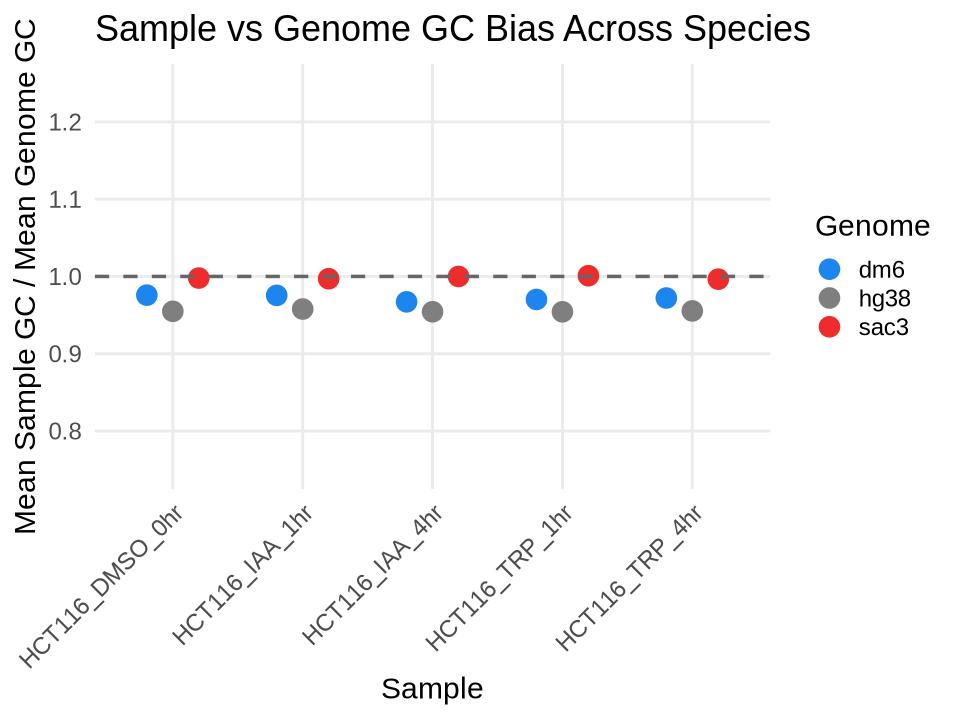

In [44]:
options(repr.plot.width = 8, repr.plot.height = 6)

LP88_relative_GCcontent_inputs_plot

### normalization factors

In [165]:
LP85_seqstats <- read.delim("~/data/experiments/LP_85/LP85_seqstats.tsv")

In [166]:
LP85_seqstats <- LP85_seqstats %>%
mutate(error_paired = abs(sac3.tagdir.normfactor.adj - dm6.tagdir.normfactor.adj)) %>%
mutate(experiment.ID = "LP85")

In [167]:
options(repr.plot.width = 4, repr.plot.height = 6.5)

LP85_normalization_factor_error_boxplot <- ggplot(LP85_seqstats %>% filter(grepl("H3K27ac", ID)) ) + 
aes(x = experiment.ID, y = error_paired) + 
geom_boxplot() +
geom_point(size = 5) + 
theme(
  axis.text = element_text(size = 16), 
  axis.title = element_text(size = 18), 
  legend.title = element_text(size = 14),
  legend.text = element_text(size = 14),
  title = element_text(size = 16),
  strip.text = element_text(size = 14)   # facet label text size
) +
coord_cartesian(ylim = c(0, 0.8))

In [168]:
seqstats_long <- LP85_seqstats %>% pivot_longer(cols = contains("tagdir.normfactor.adj"), 
                          names_to = "Species", 
                          values_to = "Norm_factor") %>%
group_by(ID) %>%
mutate(error_normfact = Norm_factor - mean(Norm_factor))

In [177]:
options(repr.plot.width = 9, repr.plot.height = 6.5)
LP85_normalization_factor_error_paired_flip <- ggplot(seqstats_long %>% filter(grepl("H3K27ac", ID))) + 
aes(x = str_remove_all(ID, "(HCT116_|_H3K27ac_1)"), y = -error_normfact, color = Species) + 
geom_hline(yintercept = 0, linetype = "dashed") +
geom_point(size = 7) +
theme(
  axis.text = element_text(size = 16), 
  axis.title = element_text(size = 18), 
  legend.title = element_text(size = 14),
  legend.text = element_text(size = 14),
  title = element_text(size = 16),
  strip.text = element_text(size = 14)) +
scale_color_manual(values = c("dodgerblue2", "firebrick2"))  + 
coord_cartesian(ylim = c(-0.4, 0.4)) + 
labs(x = "Sample", y = "Normalization Factor Error")

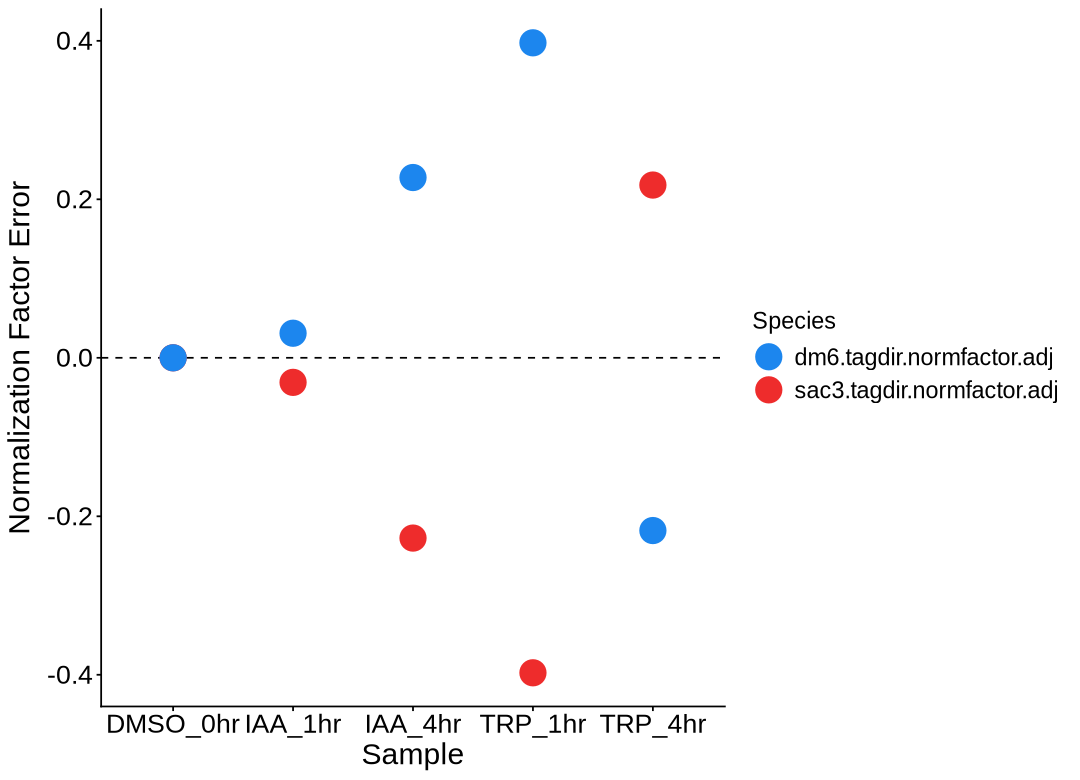

In [178]:
LP85_normalization_factor_error_paired_flip

In [179]:
ggsave("LP85_normalization_factor_error_paired_flip.pdf", LP85_normalization_factor_error_paired_flip, width = 9, height = 6.5)

# Figure 3
## LP100 HeLaS3 titration of H3K27ac

In [154]:
hist_0TSA100TSA_hg38_long$TSAratio <- as.numeric(as.character(hist_0TSA100TSA_hg38_long$TSAratio))

In [155]:
hist_0TSA100TSA_hg38_longIP <- hist_0TSA100TSA_hg38_long %>% filter(!grepl("input", Sample))

In [156]:
histograms_signalarea_calculatesizegiven <- function(input_df, id, Coverage, colname1, spikeratio) {
  # Convert strings to symbols for tidy evaluation
  id <- rlang::ensym(id)
  Coverage <- rlang::ensym(Coverage)
  colname1 <- rlang::ensym(colname1)
  spikeratio <- rlang::ensym(spikeratio)
  
  # Ensure the first column is named properly for x-axis
  colnames(input_df)[1] <- "Distance_from_center"
  x <- unique(input_df[[1]])
  
  # Get unique samples
  samples <- unique(input_df$Sample)
  
  # Initialize empty AUC matrix
  AUC_peaks <- matrix(data = NA, nrow = length(samples), ncol = 1)
  AUC_peaks_df <- data.frame(AUC_peaks, row.names = samples)
  
  # Fill AUC values per sample
  for (i in seq_along(samples)) {
    y <- input_df |>
      dplyr::filter(Sample == samples[i]) |>
      dplyr::pull({{Coverage}})
    
    AUC_peaks_df[i, ] <- DescTools::AUC(x, y, method = "trapezoid")
  }
  
  # Convert AUC column to numeric
  AUC_peaks_df <- as.data.frame(sapply(AUC_peaks_df, as.numeric))
  
  # Get treatment and spike-in info
  treatment_df <- input_df |>
    dplyr::filter(Distance_from_center == "0.04") |>
    dplyr::select(TSAratio, {{spikeratio}})
  
  treatment_vect <- dplyr::pull(treatment_df, TSAratio)
  spikeratio_vect <- dplyr::pull(treatment_df, {{spikeratio}})
  
  # Add treatment and spike-in info to AUC dataframe
  AUC_peaks_df$treatment_vect <- treatment_vect
  AUC_peaks_df$spikeratio_vect <- spikeratio_vect

    print(AUC_peaks_df)

}


In [157]:
signal_0TSA100TSA_hg38 <- histograms_signalarea_calculatesizegiven(hist_0TSA100TSA_hg38_longIP, 
  id = colname1, 
  Coverage = "Coverage", 
  colname1 = "H3K27ac", 
  spikeratio = "spikeratio")

    AUC_peaks treatment_vect spikeratio_vect
1   11.344881              0          spike1
2   10.763207              0          spike2
3   11.298995              0          spike3
4    9.086811              0          spike4
5  188.359683            100          spike1
6  241.745396            100          spike2
7  149.850469            100          spike3
8  105.199338            100          spike4
9   55.168850             25          spike1
10  52.988861             25          spike2
11  57.298769             25          spike3
12  29.947294             25          spike4
13  99.264176             50          spike1
14 110.414500             50          spike2
15  92.989927             50          spike3
16  62.951879             50          spike4
17 139.312516             75          spike1
18 165.826322             75          spike2
19 125.655244             75          spike3
20  97.302427             75          spike4
21 193.299740             95          spike1
22 225.577

In [158]:
histograms_signalarea_plotsizegiven <- function(input_df, id, Coverage, colname1, spikeratio) {
  # Convert strings to symbols for tidy evaluation
  id <- rlang::ensym(id)
  Coverage <- rlang::ensym(Coverage)
  colname1 <- rlang::ensym(colname1)
  spikeratio <- rlang::ensym(spikeratio)
  
  # Ensure the first column is named properly for x-axis
  colnames(input_df)[1] <- "Distance_from_center"
  x <- unique(input_df[[1]])
  
  # Get unique samples
  samples <- unique(input_df$Sample)
  
  # Initialize empty AUC matrix
  AUC_peaks <- matrix(data = NA, nrow = length(samples), ncol = 1)
  AUC_peaks_df <- data.frame(AUC_peaks, row.names = samples)
  
  # Fill AUC values per sample
  for (i in seq_along(samples)) {
    y <- input_df |>
      dplyr::filter(Sample == samples[i]) |>
      dplyr::pull({{Coverage}})
    
    AUC_peaks_df[i, ] <- DescTools::AUC(x, y, method = "trapezoid")
  }
  
  # Convert AUC column to numeric
  AUC_peaks_df <- as.data.frame(sapply(AUC_peaks_df, as.numeric))
  
  # Get treatment and spike-in info
  treatment_df <- input_df |>
    dplyr::filter(Distance_from_center == "0.04") |>
    dplyr::select(TSAratio, {{spikeratio}})
  
  treatment_vect <- dplyr::pull(treatment_df, TSAratio)
  spikeratio_vect <- dplyr::pull(treatment_df, {{spikeratio}})
  
  # Add treatment and spike-in info to AUC dataframe
  AUC_peaks_df$treatment_vect <- treatment_vect
  AUC_peaks_df$spikeratio_vect <- spikeratio_vect
  
  # Plot with points and regression lines per facet
  ggplot(AUC_peaks_df, aes(x = as.numeric(treatment_vect), y = AUC_peaks)) +
    geom_smooth(aes(group = 1), method = "lm", se = TRUE, span = 0.3, color = "grey50") +
    geom_point(aes(color = as.factor(treatment_vect)), size = 5, alpha = 0.9, color = "grey30") +
    facet_wrap(~ spikeratio_vect) +
    labs(
      title = paste(as.character(colname1), "Signal Area per Condition"),
      subtitle = "Dual spike-in normalized",
      x = "% TSA",
      y = "Signal Area"
    )
}


In [159]:
new_TSA_titration_dotplot <- histograms_signalarea_plotsizegiven(
  hist_0TSA100TSA_hg38_longIP, 
  id = colname1, 
  Coverage = "Coverage", 
  colname1 = "H3K27ac", 
  spikeratio = "spikeratio"
) + 
  labs(title = "ChIP-wrangler normalized H3K27ac around Peaks", 
       subtitle = "Dual spike-in normalized", 
       x = "% TSA",
      y = "Signal") +
theme(axis.text = element_text(size=20), 
        axis.title=element_text(size=20))

`geom_smooth()` using formula = 'y ~ x'


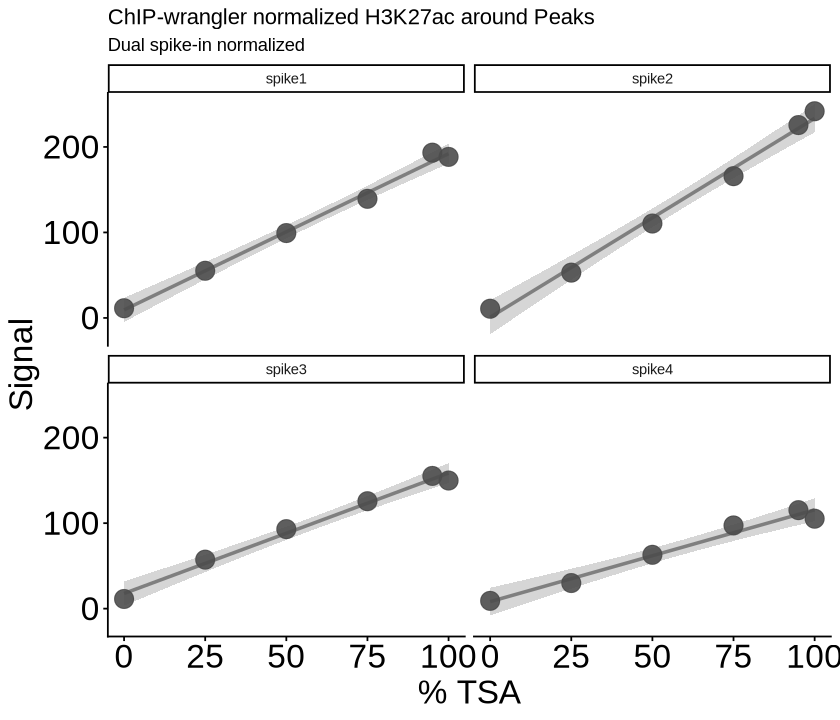

In [160]:
new_TSA_titration_dotplot

In [164]:
#ggsave("new_TSA_titration_dotplot.pdf", new_TSA_titration_dotplot, width = 8, height = 6)

### R2 values

In [163]:
scale_AUC_minmaxnorm <- function(AUC_peaks) {
  AUC_peaks$AUC_peaks <- as.numeric(AUC_peaks$AUC_peaks)
  
  TSA <- str_match(row.names(AUC_peaks), '([^_]+)(?:_[^_]+){3}$')[,2]
  TSA <- str_remove(TSA, "TSA")
  AUC_peaks$TSA <- as.numeric(TSA)
  
  AUC_peaks$ID <- row.names(AUC_peaks)

  # Extract spikeratio and H3K27ac flag
  AUC_peaks <- AUC_peaks %>%
    mutate(
      spikeratio = str_extract(ID, "spike[0-9]+"),
      is_H3K27ac = str_detect(ID, "H3K27ac")
    )

  # Get the min/max reference rows per spikeratio from specific sample rows
  min_vals <- AUC_peaks %>%
    filter(is_H3K27ac, TSA == 0) %>%
    select(spikeratio, min_val = AUC_peaks)

  max_vals <- AUC_peaks %>%
    filter(is_H3K27ac, TSA == 100) %>%
    select(spikeratio, max_val = AUC_peaks)

  # Join those values back in
  AUC_peaks <- AUC_peaks %>%
    left_join(min_vals, by = "spikeratio") %>%
    left_join(max_vals, by = "spikeratio") %>%
    mutate(
      minmaxnorm_new = if_else(
        is_H3K27ac,
        (AUC_peaks - min_val) / (max_val - min_val),
        NA_real_
      )
    )
  
  return(AUC_peaks)
}


In [169]:
samples <- unique(hist_0TSA100TSA_hg38_longIP$Sample)
colnames(hist_0TSA100TSA_hg38_longIP)[1] <- "Distance_from_center"
x <- unique(hist_0TSA100TSA_hg38_longIP$Distance_from_center)
AUC_peaks <- matrix(data = "", nrow = length(samples), ncol = 1)
AUC_peaks <- data.frame(AUC_peaks, row.names = samples)

for (i in 1:length(samples)) {

  y <- hist_0TSA100TSA_hg38_longIP %>% 
    filter(Sample == samples[i]) %>%
    select(Coverage)
  y <- pull(y, Coverage)

AUC_peaks[i, ] <- AUC(x, y, method = c("trapezoid"))

}

In [170]:
AUC_peaks_readnorm_minmaxnorm <- scale_AUC_minmaxnorm(AUC_peaks)

In [187]:
tail(AUC_peaks_readnorm_minmaxnorm)

,AUC_peaks,TSA,ID,spikeratio,is_H3K27ac,min_val,max_val,minmaxnorm_new
,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>
19,125.65524,75,HelaS3_75TSA_25DMSO_spike3_H3K27ac.Coverage,spike3,TRUE,11.298995,149.8505,0.8253701
20,97.30243,75,HelaS3_75TSA_25DMSO_spike4_H3K27ac.Coverage,spike4,TRUE,9.086811,105.1993,0.9178368
21,193.29974,95,HelaS3_95TSA_5DMSO_spike1_H3K27ac.Coverage,spike1,TRUE,11.344881,188.3597,1.0279076
22,225.57764,95,HelaS3_95TSA_5DMSO_spike2_H3K27ac.Coverage,spike2,TRUE,10.763207,241.7454,0.9300043
23,155.22875,95,HelaS3_95TSA_5DMSO_spike3_H3K27ac.Coverage,spike3,TRUE,11.298995,149.8505,1.0388179
24,115.20298,95,HelaS3_95TSA_5DMSO_spike4_H3K27ac.Coverage,spike4,TRUE,9.086811,105.1993,1.1040826


In [173]:
get_Rsquared_per_spikeratio <- function(AUC_peaks) {
  AUC_peaks <- AUC_peaks %>%
    mutate(
      spikeratio = str_extract(ID, "spike[0-9]+"),
      is_H3K27ac = str_detect(ID, "H3K27ac"),
      expected = TSA / 100
    )

  # Filter to H3K27ac rows only
  AUC_peaks_H3K27ac <- AUC_peaks %>% filter(is_H3K27ac)

  # Compute R² for each spikeratio group
  rsq_df <- AUC_peaks_H3K27ac %>%
    group_by(spikeratio) %>%
    summarize(
      rsquared = {
        observed <- minmaxnorm_new
        expected <- expected
        SSres <- sum((observed - expected)^2)
        SStotal <- sum((observed - mean(observed))^2)
        1 - (SSres / SStotal)
      },
      .groups = "drop"
    )

  return(rsq_df)
}

In [174]:
R2_values <- get_Rsquared_per_spikeratio(AUC_peaks_readnorm_minmaxnorm)

In [175]:
R2_values

spikeratio,rsquared
<chr>,<dbl>
spike1,0.9919886
spike2,0.9805284
spike3,0.9658559
spike4,0.9442818


In [176]:
library(viridis)

Loading required package: viridisLite



In [177]:
create_r2_box <- function(R2, filename, width = 4, height = 2) {
  df <- data.frame(x = 1, y = 1, R2 = R2)
   pal <- (brewer.pal(11, "RdYlGn")) 
  
  gg <- ggplot(df, aes(x, y)) +
    geom_tile(aes(fill = R2), width = 1, height = 1) +
    scale_fill_gradientn(colors = pal, limits = c(0.5, 1)) +
    geom_text(aes(label = paste0("R² = ", round(R2, 3))), 
              color = "white", size = 6) +
    theme_void() +
    theme(legend.position = "none",
          plot.margin = margin(0,0,0,0, "cm")) +
    coord_fixed(ratio = 1) 
  
  ggsave(filename, plot = gg, width = width, height = height, dpi = 300)
}

In [183]:
options(repr.plot.width = 1, repr.plot.height = 3)
# Create a data frame covering the range of R2
legend_df <- data.frame(R2 = seq(0.5, 1, length.out = 100), x = 1, y = 1)

# Plot the legend
pal <- (brewer.pal(11, "RdYlGn"))  # make a color vector

R2_legend <- ggplot(legend_df, aes(x = 1, y = as.numeric(R2), fill = as.numeric(R2))) +
  geom_tile(height = 0.01, width = 0.8) +        # small tiles make a smooth bar
  scale_fill_gradientn(colors = pal, limits = c(0.5, 1), oob = scales::squish) +
  scale_y_continuous(name = expression(R^2), breaks = seq(0.5, 1, 0.1), expand = c(0,0)) +
  theme_minimal() +
  theme(axis.title.x = element_blank(), axis.title.y = element_text(size = 14),
        axis.text.x  = element_blank(), axis.text.y  = element_text(size = 14),
        axis.ticks.x = element_blank(),
        legend.position = "none")


In [185]:
ggsave("R2_legend.pdf", R2_legend, width = 1.3, height = 3)

In [ ]:
for(i in 1:nrow(R2_values)) {
  sample_name <- R2_values$spikeratio[i]
  R2_value <- R2_values$rsquared[i]
  
  # create filename based on sample name
  filename <- paste0("R2_box_", sample_name, ".png")
  
  # generate box
  create_r2_box(R2_value, filename)
}

## Supplemental and ReadMe Plots

In [195]:
options(repr.plot.width = 9, repr.plot.height = 6.5)

hist_peaks_LP100_spikenorm <- ggplot(hist_0TSA100TSA_hg38_longIP %>% filter(spikeratio == "spike2")) + 
aes(x = Distance_from_center, y = Coverage, 
    group = Sample, color = as.factor(TSAratio)) + 
geom_line(linewidth = 1.1) +
theme(title = element_text(size = 20), 
      axis.text = element_text(size=20), 
        axis.title=element_text(size=20)) +
scale_color_manual(values = 
                        colorRampPalette(brewer.pal(9, "Blues"))
                      (7)[2:7], name = "% of Cells TSA-treated") + 
labs(title = "H3K27ac signal at Peaks", 
    x = "Distance from Peak Center", y = "Normalized Coverage")

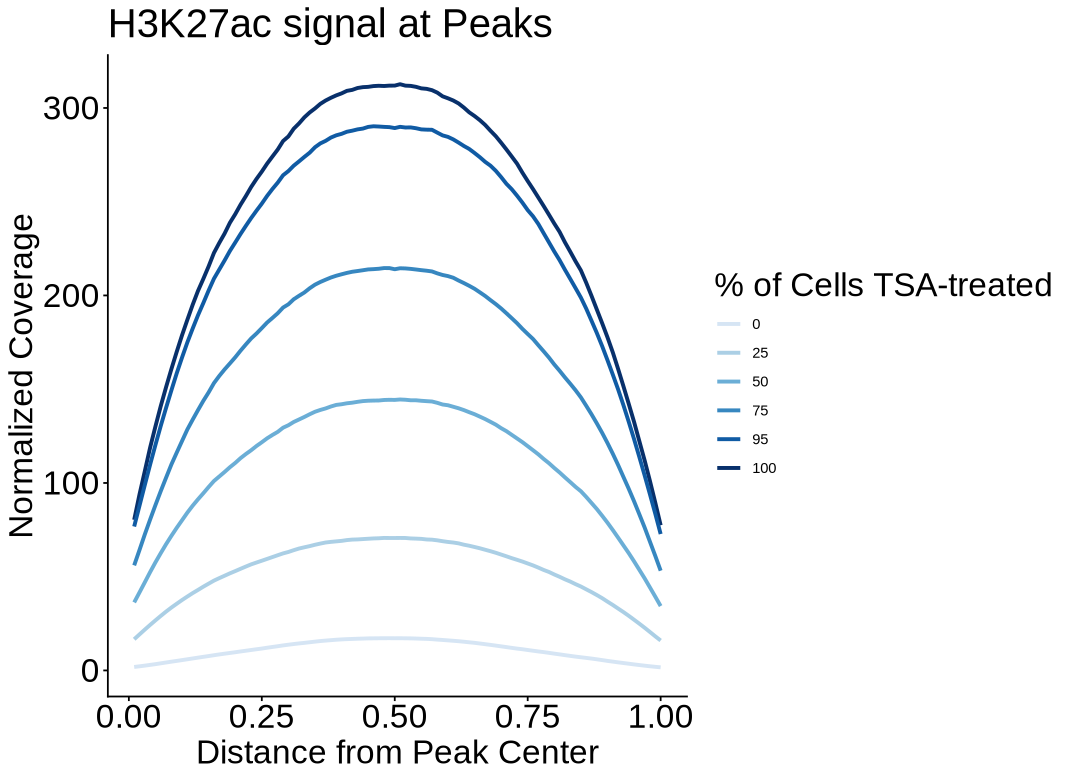

In [196]:
hist_peaks_LP100_spikenorm

In [412]:
#ggsave("hist_peaks_LP100_spikenorm.pdf", hist_peaks_LP100_spikenorm, width = 9, height = 6.5)

In [194]:
head(hist_0TSA100TSA_hg38_longIP)

Distance_from_center,Sample,Coverage,cell_type,TSAratio,DMSOratio,spikeratio,antibody
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
0.01,HelaS3_0TSA_100DMSO_spike1_H3K27ac.Coverage,1.893636,HelaS3,0,100DMSO,spike1,H3K27ac.Coverage
0.01,HelaS3_0TSA_100DMSO_spike2_H3K27ac.Coverage,1.865166,HelaS3,0,100DMSO,spike2,H3K27ac.Coverage
0.01,HelaS3_0TSA_100DMSO_spike3_H3K27ac.Coverage,1.866926,HelaS3,0,100DMSO,spike3,H3K27ac.Coverage
0.01,HelaS3_0TSA_100DMSO_spike4_H3K27ac.Coverage,1.804648,HelaS3,0,100DMSO,spike4,H3K27ac.Coverage
0.01,HelaS3_100TSA_0DMSO_spike1_H3K27ac.Coverage,64.599933,HelaS3,100,0DMSO,spike1,H3K27ac.Coverage
0.01,HelaS3_100TSA_0DMSO_spike2_H3K27ac.Coverage,80.328595,HelaS3,100,0DMSO,spike2,H3K27ac.Coverage


In [205]:
options(repr.plot.width = 9, repr.plot.height = 6.5)

hist_peaks_LP100_ratio1_spikenorm <- ggplot(hist_0TSA100TSA_hg38_longIP %>% filter(spikeratio == "spike1")) + 
aes(x = Distance_from_center, y = Coverage, 
    group = Sample, color = as.factor(TSAratio)) + 
geom_line(linewidth = 1.1) +
theme(title = element_text(size = 20), 
      axis.text = element_text(size=20), 
        axis.title=element_text(size=20)) +
scale_color_manual(values = 
                        colorRampPalette(brewer.pal(9, "Blues"))
                      (7)[2:7], name = "% of Cells TSA-treated") + 
labs(title = "H3K27ac signal at Peaks, Ratio 1", 
    x = "Distance from Peak Center", y = "Normalized Coverage")

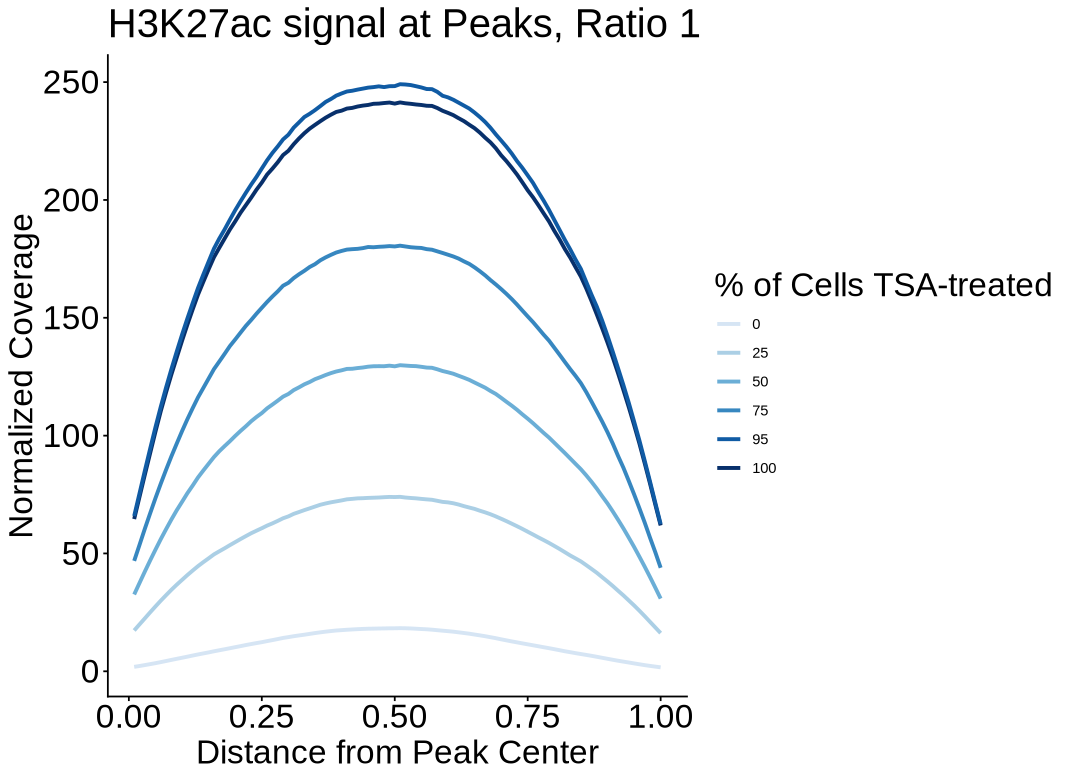

In [206]:
hist_peaks_LP100_ratio1_spikenorm

## Calculate spike-in IP efficiency

In [ ]:
histograms_signalarea_calculate_sizegiven <- function(input_df, Sample, Coverage, colname1) {
  # ensym() converts strings into symbols, so function inputs can be understood
  ### within ggplot
  Sample <- rlang::ensym(Sample)
  Coverage <- rlang::ensym(Coverage)
  colname1 <- rlang::ensym(colname1)
  # get a list of unique sample names
  samples <- unique(input_df$Sample)

  # make sure first column is named properly
  colnames(input_df)[1] <- "Distance_from_center"  
    
  # filter to only calculate between -1000 and 1000
  input_df <- input_df %>%
    dplyr::filter(Distance_from_center >= 0.04 & Distance_from_center <= 1)
    
  # get x variable
  x <- unique(input_df[[1]])
    
  # initialize empty matrix, then use to make dataframe output
  AUC_peaks <- matrix(data = "", nrow = length(samples), ncol = 1)
  AUC_peaks_df <- data.frame(AUC_peaks, row.names = samples)

  # fill in AUC dataframe for each sample
  for (i in 1:length(samples)) {

    y <- input_df |>
      dplyr::filter(Distance_from_center >= 0.04 & Distance_from_center <= 1) |>
      dplyr::filter(Sample == samples[i]) |>
      dplyr::select(Coverage)
    y <- dplyr::pull(y, Coverage)

    AUC_peaks_df[i, ] <- DescTools::AUC(x, y, method = c("trapezoid"))

  }
  # get data in numeric form
  AUC_peaks_df <- as.data.frame(sapply(AUC_peaks_df, as.numeric))

  # add in the treatment column for plotting
  treatment_df <- input_df |>
    dplyr::filter(Distance_from_center == "0.04") |>
   dplyr::select(treatment)

  treatment_vect <- dplyr::pull(treatment_df, treatment)

  # graph labels in title custom
  cell_type <- unique(input_df[[3]])
  AUC_name <- colnames(AUC_peaks_df[1])
    
    AUC_peaks_df$ID <- samples
   
    AUC_peaks_df
}

In [ ]:
histograms_signalarea_calculatetss <- function(input_df, Sample, Coverage, colname1) {
  # ensym() converts strings into symbols, so function inputs can be understood
  ### within ggplot
  Sample <- rlang::ensym(Sample)
  Coverage <- rlang::ensym(Coverage)
  colname1 <- rlang::ensym(colname1)
  # get a list of unique sample names
  samples <- unique(input_df$Sample)

  # make sure first column is named properly
  colnames(input_df)[1] <- "Distance_from_center"  
    
  # filter to only calculate between -1000 and 1000
  input_df <- input_df %>%
    dplyr::filter(Distance_from_center >= -200 & Distance_from_center <= 700)
    
  # get x variable
  x <- unique(input_df[[1]])
    
  # initialize empty matrix, then use to make dataframe output
  AUC_peaks <- matrix(data = "", nrow = length(samples), ncol = 1)
  AUC_peaks_df <- data.frame(AUC_peaks, row.names = samples)

  # fill in AUC dataframe for each sample
  for (i in 1:length(samples)) {

    y <- input_df |>
      dplyr::filter(Distance_from_center >= -200 & Distance_from_center <= 700) |>
      dplyr::filter(Sample == samples[i]) |>
      dplyr::select(Coverage)
    y <- dplyr::pull(y, Coverage)

    AUC_peaks_df[i, ] <- DescTools::AUC(x, y, method = c("trapezoid"))

  }
  # get data in numeric form
  AUC_peaks_df <- as.data.frame(sapply(AUC_peaks_df, as.numeric))

  # add in the treatment column for plotting
  treatment_df <- input_df |>
    dplyr::filter(Distance_from_center == "-200") |>
   dplyr::select(treatment)

  treatment_vect <- dplyr::pull(treatment_df, treatment)

  # graph labels in title custom
  cell_type <- unique(input_df[[3]])
  AUC_name <- colnames(AUC_peaks_df[1])
    
    AUC_peaks_df$ID <- samples
   
    AUC_peaks_df
}

In [ ]:
fly_tss_signal_LP78 <- histograms_signalarea_calculatetss(hist_tss_dm6_LP78_long, colname1 = colname1)
yeast_tss_signal_LP78 <- histograms_signalarea_calculatetss(hist_tss_sac3_LP78_long, colname1 = colname1)

fly_tss_signal_LP81 <- histograms_signalarea_calculatetss(hist_tss_dm6_LP81_long, colname1 = colname1)
fly_K4me1_signal_LP81 <- histograms_signalarea_calculatetss(hist_K4me1_dm6_LP81_long, colname1 = colname1)

fly_rna_signal_LP88 <- histograms_signalarea_calculate_sizegiven(hist_rna_dm6_LP88_long, colname1 = colname1)
fly_K36me3_signal_LP88 <- histograms_signalarea_calculate_sizegiven(hist_K36me3_dm6_LP88_long, colname1 = colname1)
fly_K4me1_signal_LP88 <- histograms_signalarea_calculate_sizegiven(hist_K4me1_dm6_LP88_long, colname1 = colname1)

fly_tss_signal_LP88 <- histograms_signalarea_calculatetss(hist_tss_dm6_LP88_long, colname1 = colname1)
yeast_rna_signal_LP88 <- histograms_signalarea_calculatetss(hist_rna_sac3_LP88_long, colname1 = colname1)
yeast_tss_signal_LP88 <- histograms_signalarea_calculatetss(hist_tss_sac3_LP88_long, colname1 = colname1)
#yeast_K4me1_signal_LP88 <- histograms_signalarea_calculatetss(hist_tss_sac3_LP88_long, colname1 = colname1)

fly_rna_signal_LP91 <- histograms_signalarea_calculate_sizegiven(hist_rna_dm6_LP91_long, colname1 = colname1)
fly_tss_signal_LP91 <- histograms_signalarea_calculatetss(hist_tss_dm6_LP91_long, colname1 = colname1)
fly_K36me3_signal_LP91 <- histograms_signalarea_calculate_sizegiven(hist_K36me3_dm6_LP91_long, colname1 = colname1)
fly_K4me1_signal_LP91 <- histograms_signalarea_calculate_sizegiven(hist_K4me1_dm6_LP91_long, colname1 = colname1)
yeast_rna_signal_LP91 <- histograms_signalarea_calculatetss(hist_rna_sac3_LP91_long, colname1 = colname1)
yeast_tss_signal_LP91 <- histograms_signalarea_calculatetss(hist_tss_sac3_LP91_long, colname1 = colname1)

fly_tss_signal_LP92 <- histograms_signalarea_calculatetss(hist_tss_dm6_LP92_long, colname1 = colname1)
yeast_tss_signal_LP92 <- histograms_signalarea_calculatetss(hist_tss_sac3_LP92_long, colname1 = colname1)

fly_rna_signal_LP95 <- histograms_signalarea_calculate_sizegiven(hist_rna_dm6_LP95_long, colname1 = colname1)
fly_tss_signal_LP95 <- histograms_signalarea_calculatetss(hist_tss_dm6_LP95_long, colname1 = colname1)
yeast_rna_signal_LP95 <- histograms_signalarea_calculatetss(hist_rna_sac3_LP95_long, colname1 = colname1)
yeast_tss_signal_LP95 <- histograms_signalarea_calculatetss(hist_tss_sac3_LP95_long, colname1 = colname1)

In [ ]:
fly_tss_signal_plot <- fly_tss_signal
fly_tss_signal_plot$antibody = str_match(fly_tss_signal$ID, '([^_]+)(?:_[^_]+){1}$')[,2]
fly_tss_signal_plot$timepoint = str_match(fly_tss_signal$ID, '([^_]+)(?:_[^_]+){3}$')[,2]
fly_tss_signal_plot$treatment = str_match(fly_tss_signal$ID, '([^_]+)(?:_[^_]+){4}$')[,2]
fly_tss_signal_plot$biorep = str_match(fly_tss_signal$ID, '([^_]+)(?:_[^_]+){2}$')[,2]
head(fly_tss_signal_plot)

In [ ]:
fly_peak_K27ac_signal$ID <- gsub("\\.Coverage", "", as.character(fly_peak_K27ac_signal$ID))
colnames(fly_peak_K27ac_signal)[1] <- "fly_K27ac_signal"

fly_peak_K4me3_signal$ID <- gsub("\\.Coverage", "", as.character(fly_peak_K4me3_signal$ID))
colnames(fly_peak_K4me3_signal)[1] <- "fly_K4me3_signal"

fly_peak_K36me3_signal$ID <- gsub("\\.Coverage", "", as.character(fly_peak_K36me3_signal$ID))
colnames(fly_peak_K36me3_signal)[1] <- "fly_K36me3_signal"

fly_tss_signal$ID <- gsub("\\.Coverage", "", as.character(fly_tss_signal$ID))
colnames(fly_tss_signal)[1] <- "fly_tss_signal"

yeast_tss_signal$ID <- gsub("\\.Coverage", "", as.character(yeast_tss_signal$ID))
colnames(yeast_tss_signal)[1] <- "yeast_tss_signal"
#head(fly_tss_IPs_signal)

## spike-in normalized plots

In [48]:
genecov_all_norm_sep_method_LP88 <- genecov_all_norm_LP88 %>% pivot_wider(
  names_from = method, values_from = Coverage
)

genecov_all_norm_sep_method_LP88 <- genecov_all_norm_sep_method_LP88 %>%
  mutate(confidence = abs(flynorm - yeastnorm)) %>%
mutate(dualnorm = (flynorm + yeastnorm)/2)

genecov_all_norm_sep_method_LP88_long <- genecov_all_norm_sep_method_LP88 %>%
  pivot_longer(cols = c("flynorm", "yeastnorm"), 
               names_to = "spike.in", 
               values_to = "Normalized.Coverage") 

ERROR: Error: object 'genecov_all_norm_LP88' not found


In [ ]:
plot_histograms_stdcurve <- function(input_df, brewer_cols) {
  xvar <- colnames(input_df)[1]
  condition_num <- length(unique(input_df[[5]]))
  antibody_name <- input_df[[6]]
  cell_name <- input_df[[3]]
  brewer_pallet <- as.numeric(brewer_cols)

  input_df |>
    ggplot2::ggplot(ggplot2::aes(x = Distance_from_tss, y = dualnorm, 
                                 group=Sample, color = as.factor(as.numeric(str_remove(timepoint, "inter"))))) +
    ggplot2::geom_line(alpha = 0.9, linewidth = 1.1) +
    ggplot2::labs(title = paste("Histogram of", antibody_name, "in", cell_name),
         x = xvar,
         y = colnames(input_df[8])) +
    ggplot2::scale_color_manual(
      values = colorRampPalette(
        RColorBrewer::brewer.pal(brewer_pallet, "Blues"))(condition_num+4)[(4):(condition_num+4)],
      name = "Condition",
      labels = as.factor(as.numeric(str_remove(unique(input_df[[5]]), "inter")))) +
    ggplot2::theme_classic() +
    ggplot2::theme(legend.position = c(0.84, 0.76),
          legend.background = element_rect(
            size=0.7, linetype="solid",
            colour ="grey20"))
}

In [46]:
histograms_signalarea_stdcurve <- function(input_df, Sample, dualnorm, colname1) {
  # ensym() converts strings into symbols, so function inputs can be understood
  ### within ggplot
  Sample <- rlang::ensym(Sample)
  dualnorm <- rlang::ensym(dualnorm)
  colname1 <- rlang::ensym(colname1)
  # get a list of unique sample names
  samples <- unique(input_df$Sample)

  # make sure first column is named properly
  colnames(input_df)[1] <- "Distance_from_center"

  # get x variable
  x <- unique(input_df[[1]])

  # initialize empty matrix, then use to make dataframe output
  AUC_peaks <- matrix(data = "", nrow = length(samples), ncol = 1)
  AUC_peaks_df <- data.frame(AUC_peaks, row.names = samples)

  # fill in AUC dataframe for each sample
  for (i in 1:length(samples)) {

    y <- input_df |>
      dplyr::filter(Sample == samples[i]) |>
      dplyr::select(dualnorm)
    y <- dplyr::pull(y, dualnorm)

    AUC_peaks_df[i, ] <- DescTools::AUC(x, y, method = c("trapezoid"))

  }
 # uncomment below if this stops working
  #AUC_peaks_df

  # get data in numeric form
  AUC_peaks_df <- as.data.frame(sapply(AUC_peaks_df, as.numeric))
  #now get this also as an output:
  AUC_peaks_df

  # add in the treatment column for plotting
  treatment_df <- input_df |>
    dplyr::filter(Distance_from_center == "-2000") |>
    dplyr::select(timepoint)

  treatment_vect <- dplyr::pull(treatment_df, timepoint)
  treatment_vect <- str_remove(treatment_vect, "inter")
 # QC the treatment_vect
  print(treatment_vect)

  # plot signal area
  ## first make colors vector
  color_vect <- unique(treatment_vect)

  # graph labels in title custom
  cell_type <- unique(input_df[[3]])
  AUC_name <- colnames(AUC_peaks_df[1])

  # plot
    AUC_peaks_df |>
    ggplot2::ggplot(ggplot2::aes(x = as.numeric(treatment_vect), 
                                 color = as.factor(as.numeric(treatment_vect)),
                                y = AUC_peaks)) +
    ggplot2::geom_point(size = 5, alpha = 0.7) +
    ggplot2::scale_color_manual(
      values = colorRampPalette(RColorBrewer::brewer.pal(9, "Spectral"))(6)[1:6],
      name = "Condition") +
    ggplot2::theme_classic() +
    ggplot2::labs(title = paste(as.character(AUC_name), "in", as.character(cell_type), "cells"),
         x = "Condition",
         y = "Signal Area")

}

In [47]:
options(repr.plot.width = 9, repr.plot.height = 7)

histograms_signalarea_stdcurve(genecov_all_norm_sep_method, colname1 = colname1) + 
  labs(title = "K9ac around Peaks", 
       subtitle = "Read normalized")

ERROR: Error: object 'genecov_all_norm_sep_method' not found
